## Converting a cleaned text file containing comments to a multi-level JSON format

1. The first line is always the name of the commenter,
2. followed by any extra lines of the comment itself

3. then the last line is the date (how many weeks ago the comment was m and some other non-relevant texts.de).

In [12]:
import json

def parse_comments(lines):
    comments = []
    stack = []  # Keeps track of the current path of nested comments
    
    # Define action keywords as constants
    ACTIONS = ['Reply', 'Share']

    i = 0
    while i < len(lines):
        # Process each comment
        commenter = lines[i].strip()  # The first line is the commenter's name
        indentation_level = lines[i].count('\t')
        commenter = commenter.lstrip('\t')  # Remove tabs from the commenter's name

        # Initialize the comment object
        comment = {
            "commenter": commenter,
            "text": "",
            "timestamp": "",  # We'll handle this later
            "replies": []
        }

        # Move to the next line for comment text
        i += 1
        while i < len(lines) and not any(action in lines[i].strip() for action in ACTIONS):
            comment["text"] += lines[i].strip() + " "  # Accumulate text
            i += 1
        
        # Clean up the comment text to remove trailing spaces
        comment["text"] = comment["text"].strip()

        # Capture the timestamp or action line
        if i < len(lines):
            timestamp_line = lines[i].strip()
            if any(action in timestamp_line for action in ACTIONS):
                comment["timestamp"] = timestamp_line
            i += 1  # Move to the next line

        # Insert comment based on indentation level
        if indentation_level == 0:
            # First level comment
            comments.append(comment)
            stack = [comment]  # Reset stack for a new top-level comment
        elif indentation_level == 1:
            # Second level comment (reply to last first-level comment)
            if stack:
                stack[0]["replies"].append(comment)
            # Update the stack for the second level
            stack = stack[:1] + [comment]
        elif indentation_level == 2:
            # Third level comment (reply to last second-level comment)
            if len(stack) >= 2:
                stack[1]["replies"].append(comment)
            # Update the stack for the third level
            stack = stack[:2] + [comment]
        
    return comments

# Read from the input file
with open('tisztitott_adat.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Parse comments
parsed_comments = parse_comments(lines)

# Write to the output file
with open('comments.json', 'w', encoding='utf-8') as json_file:
    json.dump(parsed_comments, json_file, indent=2, ensure_ascii=False)

print("Comments have been successfully parsed and written to 'comments.json'.")


Comments have been successfully parsed and written to 'comments.json'.


## Anonymization

In [16]:
import json

def anonymize_comments(comments):
    name_to_user = {}  # Dictionary to map names to user identifiers
    user_counter = 1  # Counter for user identifiers

    def get_user_id(name):
        nonlocal user_counter
        if name not in name_to_user:
            user_id = f"user{user_counter}"
            name_to_user[name] = user_id
            user_counter += 1
        return name_to_user[name]

    # Recursive function to anonymize comments
    def anonymize(comment):
        original_commenter = comment['commenter']
        comment['commenter'] = get_user_id(original_commenter)

        # Anonymize replies recursively
        for reply in comment.get('replies', []):
            anonymize(reply)

    # Anonymize each top-level comment
    for comment in comments:
        anonymize(comment)

    return comments, name_to_user

# Load the existing JSON data
with open('comments.json', 'r', encoding='utf-8') as file:
    comments_data = json.load(file)

# Anonymize the comments
anonymized_comments, name_mapping = anonymize_comments(comments_data)

# Save the anonymized comments back to a JSON file
with open('anonymized_comments.json', 'w', encoding='utf-8') as file:
    json.dump(anonymized_comments, file, indent=2, ensure_ascii=False)

# Optionally, save the mapping dictionary to a file
with open('name_mapping.json', 'w', encoding='utf-8') as file:
    json.dump(name_mapping, file, indent=2, ensure_ascii=False)

print("Anonymization complete. Check 'anonymized_comments.json' and 'name_mapping.json'.")


Anonymization complete. Check 'anonymized_comments.json' and 'name_mapping.json'.


## There are also personal names mentioned in the replies
### (when writing a reply, often the name of the person to whom the reply is written is there), so anonymization is also required there

Therefore this is a modified anonymization script.

In [17]:
import json
import re

def anonymize_comments(comments):
    name_to_user = {}  # Dictionary to map names to user identifiers
    user_counter = 1  # Counter for user identifiers

    def get_user_id(name):
        nonlocal user_counter
        if name not in name_to_user:
            user_id = f"user{user_counter}"
            name_to_user[name] = user_id
            user_counter += 1
        return name_to_user[name]

    # Recursive function to anonymize comments
    def anonymize(comment):
        original_commenter = comment['commenter']
        comment['commenter'] = get_user_id(original_commenter)

        # Replace commenter names in the text field using regex
        for name in name_to_user.keys():
            # Use regex to replace whole words only
            pattern = r'\b' + re.escape(name) + r'\b'
            comment['text'] = re.sub(pattern, name_to_user[name], comment['text'])

        # Anonymize replies recursively
        for reply in comment.get('replies', []):
            anonymize(reply)

    # Anonymize each top-level comment
    for comment in comments:
        anonymize(comment)

    return comments, name_to_user

# Load the existing JSON data
with open('comments.json', 'r', encoding='utf-8') as file:
    comments_data = json.load(file)

# Anonymize the comments
anonymized_comments, name_mapping = anonymize_comments(comments_data)

# Save the anonymized comments back to a JSON file
with open('anonymized_comments.json', 'w', encoding='utf-8') as file:
    json.dump(anonymized_comments, file, indent=2, ensure_ascii=False)

# Optionally, save the mapping dictionary to a file
with open('name_mapping.json', 'w', encoding='utf-8') as file:
    json.dump(name_mapping, file, indent=2, ensure_ascii=False)

print("Anonymization complete. Check 'anonymized_comments.json' and 'name_mapping.json'.")


Anonymization complete. Check 'anonymized_comments.json' and 'name_mapping.json'.


## Need a 'sentiment' field too
Thisis the preparation  for the sentiment classification process.

In [23]:
import json
from collections import OrderedDict

def add_sentiment_field(comments):
    # Recursive function to add the sentiment field
    def add_sentiment(comment):
        # Create an ordered dictionary to maintain the order of fields
        updated_comment = OrderedDict()
        
        # Add fields in the desired order
        updated_comment['commenter'] = comment['commenter']
        updated_comment['text'] = comment['text']
        updated_comment['timestamp'] = comment['timestamp']
        updated_comment['sentiment'] = ""  # Empty string for sentiment
        updated_comment['replies'] = comment.get('replies', [])

        # Update the comment with the ordered dictionary
        comment.clear()  # Clear the original dictionary
        comment.update(updated_comment)  # Update with ordered fields
        
        # Analyze replies recursively
        for reply in comment.get('replies', []):
            add_sentiment(reply)

    # Add sentiment field to each top-level comment
    for comment in comments:
        add_sentiment(comment)

# Load the existing JSON data
with open('anonymized_comments.json', 'r', encoding='utf-8') as file:
    comments_data = json.load(file)

# Add the sentiment field
add_sentiment_field(comments_data)

# Save the updated comments back to a JSON file
with open('anonymized_comments_with_empty_sentiment.json', 'w', encoding='utf-8') as file:
    json.dump(comments_data, file, indent=2, ensure_ascii=False)

print("Sentiment field added. Check 'anonymized_comments_with_empty_sentiment.json'.")


Sentiment field added. Check 'anonymized_comments_with_empty_sentiment.json'.


## Sentiment analysis via API

In [1]:
import requests
import json

In [2]:
import os
from groq import Groq

# Ensure the API key is correctly set in your environment variables
os.environ["GROQ_API_KEY"] = "YOUR_API_KEY"

# Create a Groq client instance
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

In [9]:
# Load the JSON file
with open("anonymized_comments_with_empty_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to analyze sentiment for each comment, including nested replies
def analyze_sentiment_recursively(comment):
    # Analyze sentiment of the current comment's text
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"Rate the sentiment of the following comment from 1 to 10, and provide only the number: '{comment['text']}'",
            }
        ],
        model="llama-3.1-70b-versatile",  # Adjust to desired model
    )
    
    # Get the sentiment score and update the comment's sentiment field
    sentiment_score = chat_completion.choices[0].message.content.strip()
    comment["sentiment"] = sentiment_score

    # Process replies recursively if they exist
    for reply in comment.get("replies", []):
        analyze_sentiment_recursively(reply)

# Run sentiment analysis on each top-level comment
for comment in comments_data:
    analyze_sentiment_recursively(comment)

# Save the updated JSON data to a new file
with open("anonymized_comments_with_sentiment.json", "w", encoding="utf-8") as file:
    json.dump(comments_data, file, indent=4, ensure_ascii=False)

print("Sentiment analysis complete. Updated file saved as 'anonymized_comments_with_sentiment.json'.")


Sentiment analysis complete. Updated file saved as 'anonymized_comments_with_sentiment.json'.


In [4]:
import json
import time  # Import time for delays
from tqdm import tqdm  # Import tqdm for progress bar

# Load the JSON file
with open("anonymized_comments_with_empty_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to analyze sentiment for each comment, including nested replies
def analyze_sentiment_recursively(comment, retries=3):
    attempt = 0
    while attempt < retries:
        try:
            # Analyze sentiment of the current comment's text
            chat_completion = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": f"Rate the sentiment of the following comment from 1 to 10, and provide only the number: '{comment['text']}'",
                    }
                ],
                model="llama-3.1-70b-versatile",  # Adjust to desired model
            )
            
            # Get the sentiment score and update the comment's sentiment field
            sentiment_score = chat_completion.choices[0].message.content.strip()
            comment["sentiment"] = sentiment_score
            break  # Break out of retry loop if successful
            
        except Exception as e:
            attempt += 1
            print(f"Attempt {attempt} failed: {e}")
            if attempt < retries:
                time.sleep(5)  # Wait before retrying
            else:
                comment["sentiment"] = "error"  # Mark sentiment as 'error' if all retries fail

    # Process replies recursively if they exist
    for reply in comment.get("replies", []):
        analyze_sentiment_recursively(reply)

# Run sentiment analysis on each top-level comment with a progress bar and reduce load
for comment in tqdm(comments_data, desc="Processing comments"):
    analyze_sentiment_recursively(comment)
    time.sleep(1)  # Delay to reduce load

# Save the updated JSON data to a new file
with open("anonymized_comments_with_sentiment_llama-3.1-70b-versatile_v5.json", "w", encoding="utf-8") as file:
    json.dump(comments_data, file, indent=4, ensure_ascii=False)

print("Sentiment analysis complete. Updated file saved as 'anonymized_comments_with_sentiment_llama-3.1-70b-versatile_v5.json'.")


Processing comments: 100%|████████████████████| 192/192 [27:56<00:00,  8.73s/it]

Sentiment analysis complete. Updated file saved as 'anonymized_comments_with_sentiment_llama-3.1-70b-versatile_v5.json'.


In [5]:
import json
import time
from tqdm import tqdm, trange  # Import tqdm for progress bar and trange for retries

# Load the JSON file
with open("anonymized_comments_with_empty_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to analyze sentiment for each comment, including nested replies
def analyze_sentiment_recursively(comment, retries=3):
    attempt = 0
    retry_bar = tqdm(total=retries, desc="Retries", leave=False, position=1)  # Retry bar
    
    while attempt < retries:
        try:
            # Analyze sentiment of the current comment's text
            chat_completion = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": f"Rate the sentiment of the following comment from 1 to 10, and provide only the number: '{comment['text']}'",
                    }
                ],
                model="llama-3.1-8b-instant",  # Adjust to desired model
            )
            
            # Get the sentiment score and update the comment's sentiment field
            sentiment_score = chat_completion.choices[0].message.content.strip()
            comment["sentiment"] = sentiment_score
            retry_bar.close()  # Close retry bar on success
            break  # Break out of retry loop if successful
            
        except Exception as e:
            attempt += 1
            retry_bar.update(1)  # Update retry progress
            print(f"Attempt {attempt} failed: {e}")
            if attempt < retries:
                time.sleep(5)  # Wait before retrying
            else:
                comment["sentiment"] = "error"  # Mark sentiment as 'error' if all retries fail

    # Process replies recursively if they exist
    for reply in comment.get("replies", []):
        analyze_sentiment_recursively(reply)
    retry_bar.close()  # Ensure retry bar is closed

# Run sentiment analysis on each top-level comment with a progress bar and reduce load
for comment in tqdm(comments_data, desc="Processing comments", position=0):
    analyze_sentiment_recursively(comment)
    time.sleep(1)  # Delay to reduce load

# Save the updated JSON data to a new file
with open("anonymized_comments_with_sentiment_llama-3.1-8b-instant_v1.json", "w", encoding="utf-8") as file:
    json.dump(comments_data, file, indent=4, ensure_ascii=False)

print("Sentiment analysis complete. Updated file saved as 'anonymized_comments_with_sentiment_llama-3.1-8b-instant_v1.json'.")


Retries:   0%|                                            | 0/3 [00:00<?, ?it/s]
                                                                                
Retries:   0%|                                            | 0/3 [00:00<?, ?it/s]
                                                                                
Retries:   0%|                                            | 0/3 [00:00<?, ?it/s]
                                                                                
Retries:   0%|                                            | 0/3 [00:00<?, ?it/s]
                                                                                
Retries:   0%|                                            | 0/3 [00:00<?, ?it/s]
                                                                                
Retries:   0%|                                            | 0/3 [00:00<?, ?it/s]
                                                                                
Retries:   0%|              

Sentiment analysis complete. Updated file saved as 'anonymized_comments_with_sentiment_llama-3.1-8b-instant_v1.json'.


In [3]:
import json
import time
from tqdm import tqdm

# Load the JSON file
with open("anonymized_comments_with_empty_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to analyze sentiment for each comment, including nested replies
def analyze_sentiment_recursively(comment, retries=3):
    for attempt in range(retries):
        try:
            # Analyze sentiment of the current comment's text
            chat_completion = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": f"Rate the sentiment of the following comment from 1 to 10, and provide only the number: '{comment['text']}'",
                    }
                ],
                model="llama-3.1-8b-instant",
            )
            
            # Get the sentiment score and update the comment's sentiment field
            sentiment_score = chat_completion.choices[0].message.content.strip()
            comment["sentiment"] = sentiment_score
            break  # Exit retry loop if successful
            
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(5)  # Wait before retrying
            else:
                comment["sentiment"] = "error"  # Mark sentiment as 'error' if all retries fail

    # Process replies recursively if they exist
    for reply in comment.get("replies", []):
        analyze_sentiment_recursively(reply)

# Run sentiment analysis on each top-level comment with a progress bar
for comment in tqdm(comments_data, desc="Processing comments"):
    # Single retry progress bar for each comment
    with tqdm(total=3, desc="Retries", leave=False, position=1) as retry_bar:
        for retry_attempt in range(3):
            try:
                analyze_sentiment_recursively(comment)
                retry_bar.update(3)  # Complete retry bar after success
                break  # Exit retry loop if successful
            except Exception:
                retry_bar.update(1)
                time.sleep(5)  # Wait before retrying

# Save the updated JSON data to a new file
with open("anonymized_comments_with_sentiment_llama-3.1-8b-instant_v5.json", "w", encoding="utf-8") as file:
    json.dump(comments_data, file, indent=4, ensure_ascii=False)

print("Sentiment analysis complete. Updated file saved as 'anonymized_comments_with_sentiment_llama-3.1-8b-instant_v5.json'.")


Processing comments: 100%|███████████████████████████████████████████████████████████████████████████████| 192/192 [27:43<00:00,  8.66s/it]

Sentiment analysis complete. Updated file saved as 'anonymized_comments_with_sentiment_llama-3.1-8b-instant_v5.json'.


## Calculate average sentiment score for two JSON files

In [5]:
import json
import re

# Load the JSON files
with open("anonymized_comments_with_sentiment_llama-3.1-70b-versatile_v1.json", "r", encoding="utf-8") as f1, \
     open("anonymized_comments_with_sentiment_llama-3.1-70b-versatile_v2.json", "r", encoding="utf-8") as f2, \
     open("anonymized_comments_with_empty_sentiment.json", "r", encoding="utf-8") as f_base:
    
    file1_data = json.load(f1)
    file2_data = json.load(f2)
    base_data = json.load(f_base)

# Helper function to extract the first valid score from a text response
def extract_sentiment_score(text):
    # Look for the first occurrence of a number (1-10)
    match = re.search(r'\b(1[0]|[1-9])\b', text)
    if match:
        return int(match.group())
    else:
        return None  # Return None if no valid number is found

# Recursive function to calculate the average sentiment
def calculate_average_sentiment(comment1, comment2, base_comment):
    scores = []
    
    # Extract and add scores from each version file
    for comment in [comment1, comment2]:
        sentiment_text = comment.get("sentiment", "")
        if sentiment_text.isdigit():
            scores.append(int(sentiment_text))
        else:
            extracted_score = extract_sentiment_score(sentiment_text)
            if extracted_score is not None:
                scores.append(extracted_score)
    
    # Filter out None values from scores before averaging
    valid_scores = [score for score in scores if score is not None]
    
    # Calculate the average and update the base comment if there are valid scores
    if valid_scores:
        average_score = sum(valid_scores) / len(valid_scores)
        base_comment["sentiment"] = round(average_score, 2)
    else:
        base_comment["sentiment"] = None  # If no valid scores, set to None or leave it as an empty string if preferred
    
    # Process replies recursively
    for reply1, reply2, base_reply in zip(comment1.get("replies", []), 
                                          comment2.get("replies", []), 
                                          base_comment.get("replies", [])):
        calculate_average_sentiment(reply1, reply2, base_reply)

# Run the averaging process
for comment1, comment2, base_comment in zip(file1_data, file2_data, base_data):
    calculate_average_sentiment(comment1, comment2, base_comment)

# Save the output to a new JSON file
with open("anonymized_comments_with_average_sentiment.json", "w", encoding="utf-8") as output_file:
    json.dump(base_data, output_file, indent=4, ensure_ascii=False)

print("Average sentiment analysis complete. Output saved to 'anonymized_comments_with_average_sentiment.json'.")


Average sentiment analysis complete. Output saved to 'anonymized_comments_with_average_sentiment.json'.


## Calculate average sentiment score for multiple JSON files

In [4]:
import json
import re

# Define a list of input JSON filenames
input_files = [
    "anonymized_comments_with_sentiment_llama-3.1-70b-versatile_v1.json",
    "anonymized_comments_with_sentiment_llama-3.1-70b-versatile_v2.json",
    "anonymized_comments_with_sentiment_llama-3.1-70b-versatile_v3.json",
    "anonymized_comments_with_sentiment_llama-3.1-70b-versatile_v4.json",
    "anonymized_comments_with_sentiment_llama-3.1-70b-versatile_v5.json",
    "anonymized_comments_with_sentiment_llama-3.1-8b-instant_v1.json",
    "anonymized_comments_with_sentiment_llama-3.1-8b-instant_v2.json",
    "anonymized_comments_with_sentiment_llama-3.1-8b-instant_v3.json",
    "anonymized_comments_with_sentiment_llama-3.1-8b-instant_v4.json",
    "anonymized_comments_with_sentiment_llama-3.1-8b-instant_v5.json",
    # Add more file paths as needed
]

# Load all JSON data into a list of dictionaries
json_data_list = []
for file in input_files:
    with open(file, "r", encoding="utf-8") as f:
        json_data_list.append(json.load(f))

# Load the base JSON file where we will store the averages
with open("anonymized_comments_with_empty_sentiment.json", "r", encoding="utf-8") as f_base:
    base_data = json.load(f_base)

# Helper function to extract the first valid score from a text response
def extract_sentiment_score(text):
    # Look for the first occurrence of a number (1-10)
    match = re.search(r'\b(1[0]|[1-9])\b', text)
    if match:
        return int(match.group())
    else:
        return None  # Return None if no valid number is found

# Recursive function to calculate the average sentiment across multiple comments, handling nested replies
def calculate_average_sentiment(comment_list, base_comment):
    scores = []
    
    # Extract and add scores from each comment version
    for comment in comment_list:
        sentiment_text = comment.get("sentiment", "")
        if sentiment_text.isdigit():
            scores.append(int(sentiment_text))
        else:
            extracted_score = extract_sentiment_score(sentiment_text)
            if extracted_score is not None:
                scores.append(extracted_score)
    
    # Filter out None values from scores before averaging
    valid_scores = [score for score in scores if score is not None]
    
    # Calculate the average and update the base comment if there are valid scores
    if valid_scores:
        average_score = sum(valid_scores) / len(valid_scores)
        base_comment["sentiment"] = round(average_score, 2)
    else:
        base_comment["sentiment"] = None  # Set to None if no valid scores
    
    # Process replies recursively at all levels
    for i, reply_lists in enumerate(zip(*(comment.get("replies", []) for comment in comment_list))):
        # If base_comment doesn't have enough replies, add a placeholder dictionary
        if i >= len(base_comment["replies"]):
            base_comment["replies"].append({})

        # Recursively calculate sentiment for each reply
        calculate_average_sentiment(reply_lists, base_comment["replies"][i])

# Run the averaging process on all comments in each JSON file
for base_comment, *comment_versions in zip(base_data, *json_data_list):
    calculate_average_sentiment(comment_versions, base_comment)

# Save the output to a new JSON file
with open("anonymized_comments_with_average_sentiment.json", "w", encoding="utf-8") as output_file:
    json.dump(base_data, output_file, indent=4, ensure_ascii=False)

print("Average sentiment analysis complete. Output saved to 'anonymized_comments_with_average_sentiment.json'.")


Average sentiment analysis complete. Output saved to 'anonymized_comments_with_average_sentiment.json'.


## And now is the time to put the data into charts
### Sentiment scores of total replies

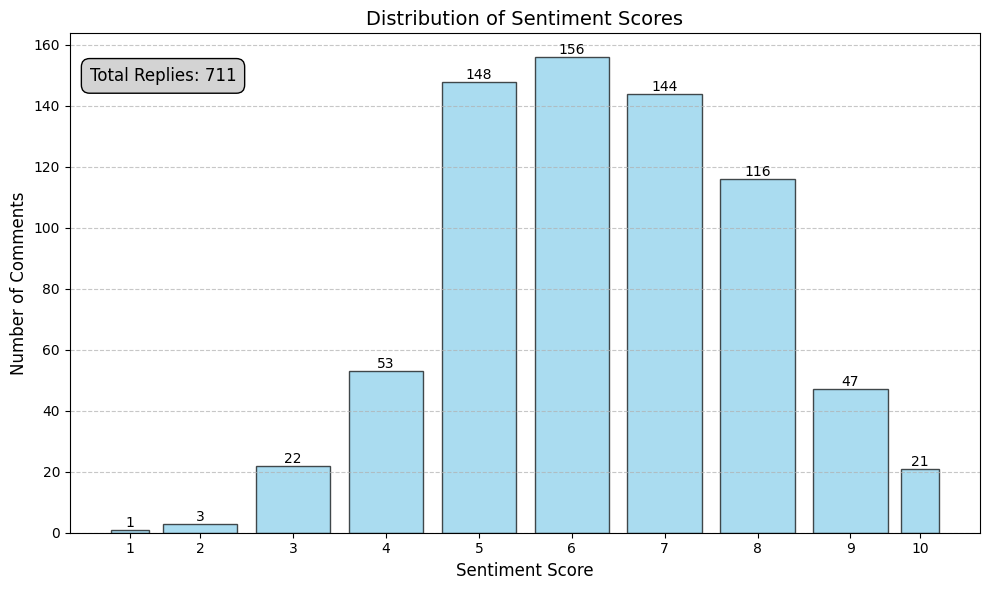

In [43]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Recursive function to extract sentiment scores from all levels
def extract_sentiment_scores(comments):
    scores = []
    for comment in comments:
        sentiment = comment.get("sentiment")
        if sentiment is not None:
            try:
                scores.append(float(sentiment))  # Keep decimal precision
            except ValueError:
                pass  # Skip if the sentiment cannot be converted to float
        
        # Recursively extract scores from replies
        replies = comment.get("replies", [])
        scores.extend(extract_sentiment_scores(replies))
    
    return scores

# Extract all sentiment scores
sentiment_scores = extract_sentiment_scores(comments_data)

# Define custom bins as per specified ranges
custom_bins = [1, 1.51, 2.51, 3.51, 4.51, 5.51, 6.51, 7.51, 8.51, 9.51, 10.01]

# Create a histogram of the sentiment scores with custom bins
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(sentiment_scores, bins=custom_bins, color='skyblue', edgecolor='black', alpha=0.7, rwidth=0.8)

# Add data labels on top of each bar
for count, patch in zip(counts, patches):
    height = patch.get_height()
    if height > 0:  # Only label non-zero counts
        plt.text(patch.get_x() + patch.get_width() / 2, height, int(height), ha='center', va='bottom', fontsize=10)

# Set labels and title
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.title('Distribution of Sentiment Scores', fontsize=14)
plt.xticks([(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)], range(1, 11))  # Center x-ticks for each bin
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total replies as a text annotation
total_replies = len(sentiment_scores)
plt.text(0.82, max(counts) * 0.95, f'Total Replies: {total_replies}', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Show the plot
plt.tight_layout()
plt.savefig('Distribution_of_Sentiment_Scores_total_replies.png')
plt.show()



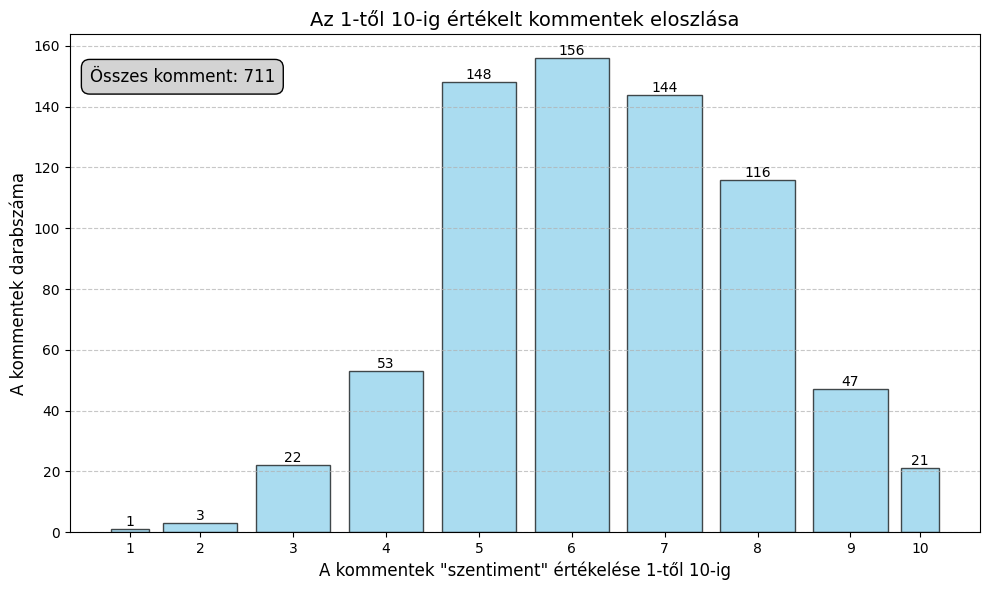

In [78]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Recursive function to extract sentiment scores from all levels
def extract_sentiment_scores(comments):
    scores = []
    for comment in comments:
        sentiment = comment.get("sentiment")
        if sentiment is not None:
            try:
                scores.append(float(sentiment))  # Keep decimal precision
            except ValueError:
                pass  # Skip if the sentiment cannot be converted to float
        
        # Recursively extract scores from replies
        replies = comment.get("replies", [])
        scores.extend(extract_sentiment_scores(replies))
    
    return scores

# Extract all sentiment scores
sentiment_scores = extract_sentiment_scores(comments_data)

# Define custom bins as per specified ranges
custom_bins = [1, 1.51, 2.51, 3.51, 4.51, 5.51, 6.51, 7.51, 8.51, 9.51, 10.01]

# Create a histogram of the sentiment scores with custom bins
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(sentiment_scores, bins=custom_bins, color='skyblue', edgecolor='black', alpha=0.7, rwidth=0.8)

# Add data labels on top of each bar
for count, patch in zip(counts, patches):
    height = patch.get_height()
    if height > 0:  # Only label non-zero counts
        plt.text(patch.get_x() + patch.get_width() / 2, height, int(height), ha='center', va='bottom', fontsize=10)

# Set labels and title (translated to Hungarian)
plt.xlabel('A kommentek \"szentiment\" értékelése 1-től 10-ig', fontsize=12)
plt.ylabel('A kommentek darabszáma', fontsize=12)
plt.title('Az 1-től 10-ig értékelt kommentek eloszlása', fontsize=14)
plt.xticks([(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)], range(1, 11))  # Center x-ticks for each bin
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total replies as a text annotation (translated to Hungarian)
total_replies = len(sentiment_scores)
plt.text(0.82, max(counts) * 0.95, f'Összes komment: {total_replies}', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Show the plot
plt.tight_layout()
plt.savefig('Distribution_of_Sentiment_Scores_total_replies_HUN.png')
plt.show()


### Sentiment scores in five categories of total replies

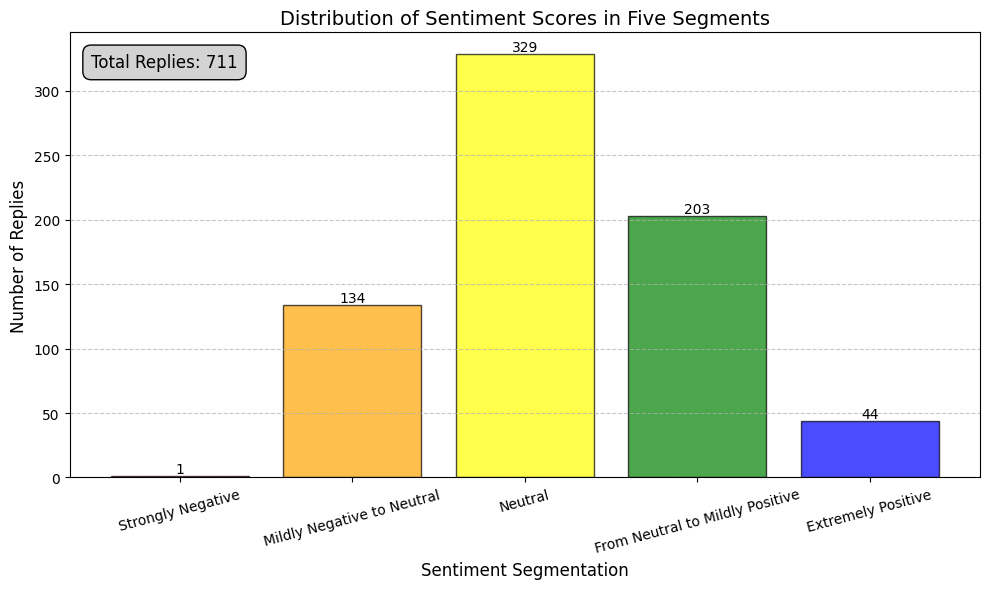

In [36]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Recursive function to extract sentiment scores from all levels
def extract_sentiment_scores(comments):
    scores = []
    for comment in comments:
        sentiment = comment.get("sentiment")
        if sentiment is not None:
            try:
                # Directly add the raw float score to the list
                scores.append(float(sentiment))
            except ValueError:
                pass  # Skip if the sentiment cannot be converted to float
        
        # Recursively extract scores from replies
        replies = comment.get("replies", [])
        scores.extend(extract_sentiment_scores(replies))
    
    return scores

# Extract all sentiment scores
sentiment_scores = extract_sentiment_scores(comments_data)

# Define the categories
categories = {
    "Strongly Negative": 0,
    "Mildly Negative to Neutral": 0,
    "Neutral": 0,
    "From Neutral to Mildly Positive": 0,
    "Extremely Positive": 0
}

# Adjusted 5-segment code
for score in sentiment_scores:
    if 1 <= score < 2:
        categories["Strongly Negative"] += 1
    elif 2 <= score < 5:
        categories["Mildly Negative to Neutral"] += 1
    elif 5 <= score <= 7:  # Explicitly includes 7
        categories["Neutral"] += 1
    elif 7 < score <= 9:    # Starts above 7 and goes to 9 inclusive
        categories["From Neutral to Mildly Positive"] += 1
    elif 9 < score <= 10:   # Starts just above 9 and goes to 10 inclusive
        categories["Extremely Positive"] += 1

# Create a bar chart for the categories
labels = list(categories.keys())
values = list(categories.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['red', 'orange', 'yellow', 'green', 'blue'], edgecolor='black', alpha=0.7)

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Sentiment Segmentation', fontsize=12)
plt.ylabel('Number of Replies', fontsize=12)
plt.title('Distribution of Sentiment Scores in Five Segments', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total replies as a text annotation
total_replies = len(sentiment_scores)
plt.text(-0.09, max(counts) * 2.04, f'Total Replies: {total_replies}', ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Show the plot
plt.tight_layout()
plt.savefig('Distribution_of_Sentiment_Scores_total_replies_in_Five_Segments.png')
plt.show()

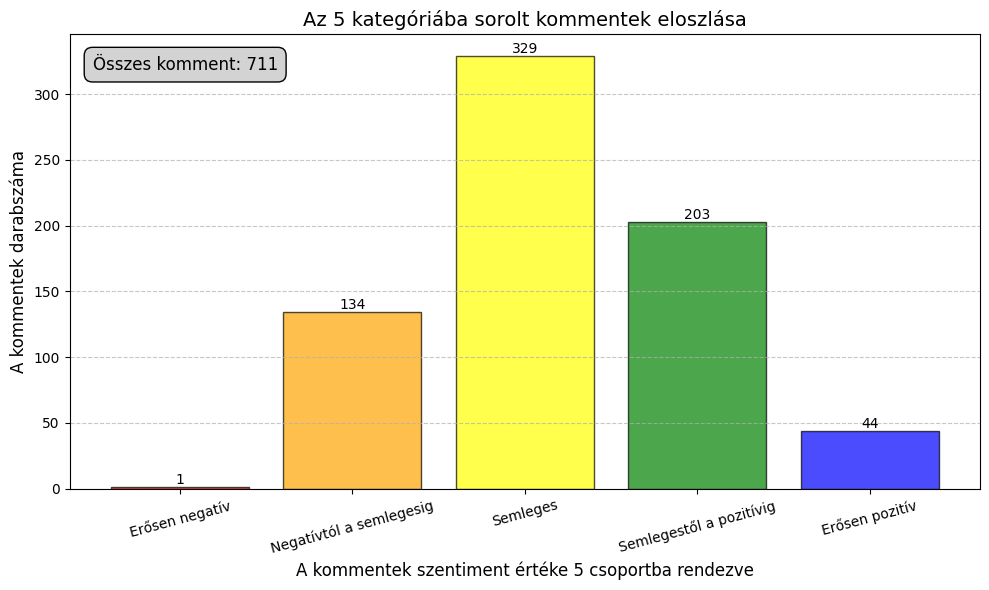

In [77]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Recursive function to extract sentiment scores from all levels
def extract_sentiment_scores(comments):
    scores = []
    for comment in comments:
        sentiment = comment.get("sentiment")
        if sentiment is not None:
            try:
                # Directly add the raw float score to the list
                scores.append(float(sentiment))
            except ValueError:
                pass  # Skip if the sentiment cannot be converted to float
        
        # Recursively extract scores from replies
        replies = comment.get("replies", [])
        scores.extend(extract_sentiment_scores(replies))
    
    return scores

# Extract all sentiment scores
sentiment_scores = extract_sentiment_scores(comments_data)

# Define the categories
categories = {
    "Erősen negatív": 0,
    "Negatívtól a semlegesig": 0,
    "Semleges": 0,
    "Semlegestől a pozitívig": 0,
    "Erősen pozitív": 0
}

# Adjusted 5-segment code
for score in sentiment_scores:
    if 1 <= score < 2:
        categories["Erősen negatív"] += 1
    elif 2 <= score < 5:
        categories["Negatívtól a semlegesig"] += 1
    elif 5 <= score <= 7:  # Explicitly includes 7
        categories["Semleges"] += 1
    elif 7 < score <= 9:    # Starts above 7 and goes to 9 inclusive
        categories["Semlegestől a pozitívig"] += 1
    elif 9 < score <= 10:   # Starts just above 9 and goes to 10 inclusive
        categories["Erősen pozitív"] += 1

# Create a bar chart for the categories
labels = list(categories.keys())
values = list(categories.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['red', 'orange', 'yellow', 'green', 'blue'], edgecolor='black', alpha=0.7)

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('A kommentek szentiment értéke 5 csoportba rendezve', fontsize=12)
plt.ylabel('A kommentek darabszáma', fontsize=12)
plt.title('Az 5 kategóriába sorolt kommentek eloszlása', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total replies as a text annotation
total_replies = len(sentiment_scores)
plt.text(0.03, max(counts) * 5.4, f'Összes komment: {total_replies}', ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Show the plot
plt.tight_layout()
plt.savefig('Distribution_of_Sentiment_Scores_total_replies_in_Five_Segments_HUN.png')
plt.show()

### Sentiment scores of every user's first comment in five categories

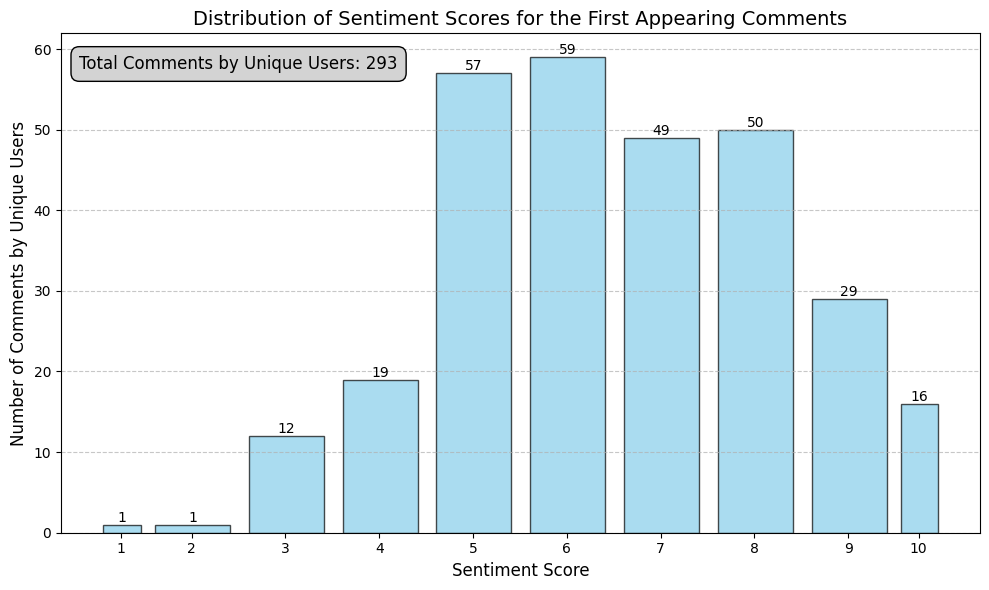

In [53]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract the first comment from each user
def extract_first_comments(comments, seen_users, first_comments):
    for comment in comments:
        commenter = comment.get("commenter")
        sentiment = comment.get("sentiment")
        
        # Check if the commenter is not already seen
        if commenter and commenter not in seen_users:
            seen_users.add(commenter)
            first_comments.append({"commenter": commenter, "sentiment": sentiment})
        
        # Recursively check replies
        replies = comment.get("replies", [])
        extract_first_comments(replies, seen_users, first_comments)

# Initialize data structures
seen_users = set()
first_comments = []

# Extract first comments
extract_first_comments(comments_data, seen_users, first_comments)

# Define custom bins as per specified ranges
custom_bins = [1, 1.51, 2.51, 3.51, 4.51, 5.51, 6.51, 7.51, 8.51, 9.51, 10.01]

# Collect sentiment scores for first comments only
sentiment_scores = []
for comment in first_comments:
    sentiment = comment.get("sentiment")
    if sentiment is not None:
        try:
            score = float(sentiment)
            sentiment_scores.append(score)
        except ValueError:
            pass  # Skip if the sentiment cannot be converted to float

# Create a histogram of the sentiment scores with custom bins
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(sentiment_scores, bins=custom_bins, color='skyblue', edgecolor='black', alpha=0.7, rwidth=0.8)

# Add data labels on top of each bar
for count, bin in zip(counts, patches):
    height = bin.get_height()
    if height > 0:  # Only label non-zero counts
        plt.text(bin.get_x() + bin.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Number of Comments by Unique Users', fontsize=12)
plt.title('Distribution of Sentiment Scores for the First Appearing Comments', fontsize=14)
plt.xticks([1.25, 2, 3, 4, 5, 6, 7, 8, 9, 9.75], labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])

# Add total comments annotation
total_first_comments = len(sentiment_scores)
plt.text(2.5, max(counts) * 0.975, f'Total Comments by Unique Users: {total_first_comments}', ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('Distribution_of_Sentiment_Scores_first_comments.png')
plt.show()


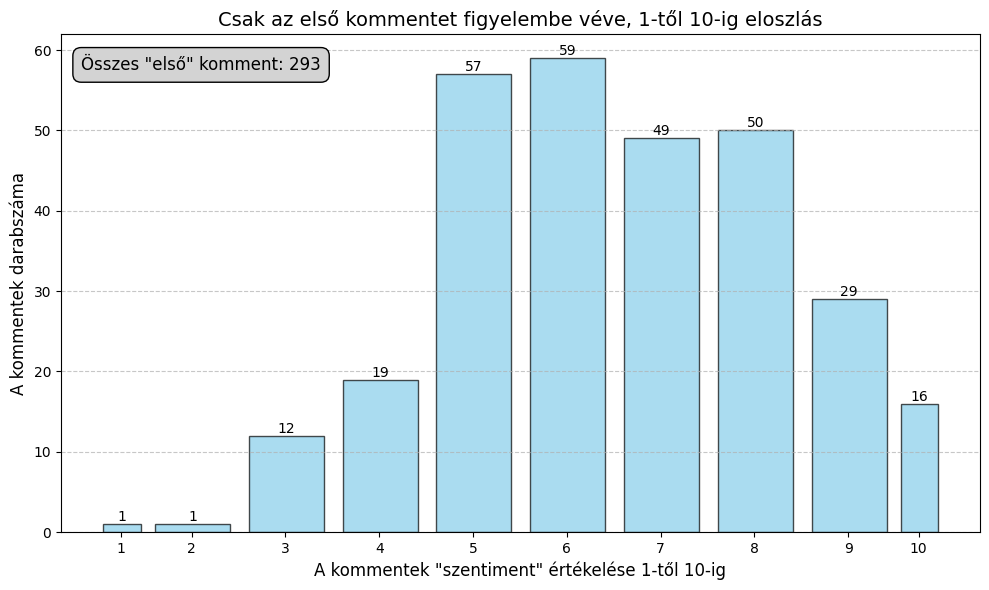

In [61]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract the first comment from each user
def extract_first_comments(comments, seen_users, first_comments):
    for comment in comments:
        commenter = comment.get("commenter")
        sentiment = comment.get("sentiment")
        
        # Check if the commenter is not already seen
        if commenter and commenter not in seen_users:
            seen_users.add(commenter)
            first_comments.append({"commenter": commenter, "sentiment": sentiment})
        
        # Recursively check replies
        replies = comment.get("replies", [])
        extract_first_comments(replies, seen_users, first_comments)

# Initialize data structures
seen_users = set()
first_comments = []

# Extract first comments
extract_first_comments(comments_data, seen_users, first_comments)

# Define custom bins as per specified ranges
custom_bins = [1, 1.51, 2.51, 3.51, 4.51, 5.51, 6.51, 7.51, 8.51, 9.51, 10.01]

# Collect sentiment scores for first comments only
sentiment_scores = []
for comment in first_comments:
    sentiment = comment.get("sentiment")
    if sentiment is not None:
        try:
            score = float(sentiment)
            sentiment_scores.append(score)
        except ValueError:
            pass  # Skip if the sentiment cannot be converted to float

# Create a histogram of the sentiment scores with custom bins
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(sentiment_scores, bins=custom_bins, color='skyblue', edgecolor='black', alpha=0.7, rwidth=0.8)

# Add data labels on top of each bar
for count, bin in zip(counts, patches):
    height = bin.get_height()
    if height > 0:  # Only label non-zero counts
        plt.text(bin.get_x() + bin.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.xlabel('A kommentek \"szentiment\" értékelése 1-től 10-ig', fontsize=12)
plt.ylabel('A kommentek darabszáma', fontsize=12)
plt.title('Csak az első kommentet figyelembe véve, 1-től 10-ig eloszlás', fontsize=14)
plt.xticks([1.25, 2, 3, 4, 5, 6, 7, 8, 9, 9.75], labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])

# Add total comments annotation
total_first_comments = len(sentiment_scores)
plt.text(2.1, max(counts) * 0.975, f'Összes \"első\" komment: {total_first_comments}', ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('Distribution_of_Sentiment_Scores_first_comments_HUN.png')
plt.show()


### Sentiment scores of every user's first comment in five categories

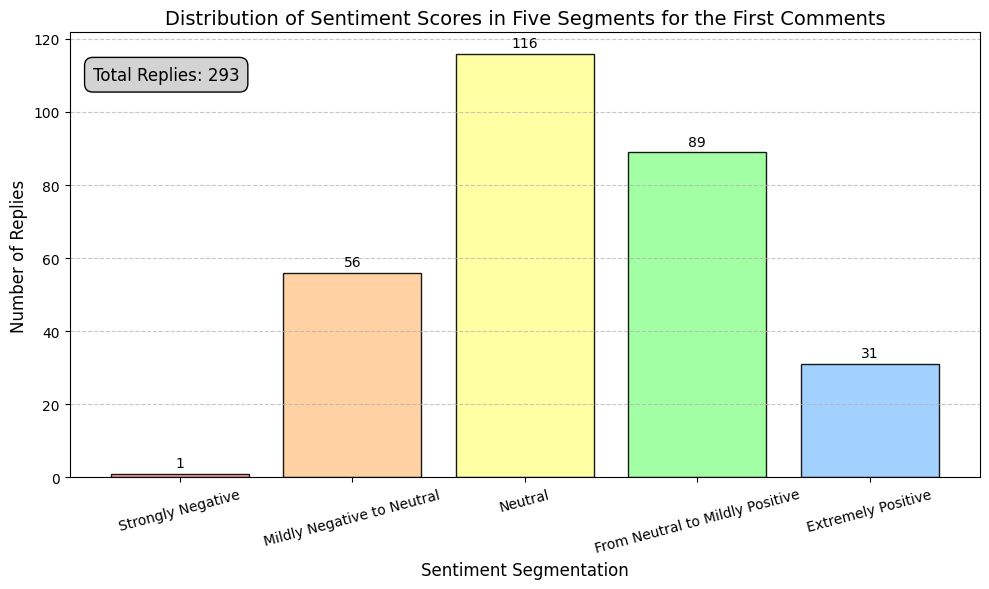

In [88]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract the first comment from each user
def extract_first_comments(comments, seen_users, first_comments):
    for comment in comments:
        commenter = comment.get("commenter")
        sentiment = comment.get("sentiment")
        
        # Check if the commenter is not already seen
        if commenter and commenter not in seen_users:
            seen_users.add(commenter)
            first_comments.append({"commenter": commenter, "sentiment": sentiment})
        
        # Recursively check replies
        replies = comment.get("replies", [])
        extract_first_comments(replies, seen_users, first_comments)

# Initialize data structures
seen_users = set()
first_comments = []

# Extract first comments
extract_first_comments(comments_data, seen_users, first_comments)

# Define the categories
categories = {
    "Strongly Negative": 0,
    "Mildly Negative to Neutral": 0,
    "Neutral": 0,
    "From Neutral to Mildly Positive": 0,
    "Extremely Positive": 0
}

# Classify the scores
for comment in first_comments:
    sentiment = comment.get("sentiment")
    if sentiment is not None:
        try:
            score = float(sentiment)  # Use the raw float without rounding
            if 1 <= score < 2:
                categories["Strongly Negative"] += 1
            elif 2 <= score < 5:
                categories["Mildly Negative to Neutral"] += 1
            elif 5 <= score <= 7:
                categories["Neutral"] += 1
            elif 7 < score <= 9:
                categories["From Neutral to Mildly Positive"] += 1
            elif 9 < score <= 10:
                categories["Extremely Positive"] += 1
        except ValueError:
            pass  # Skip if the sentiment cannot be converted to float


# Create a bar chart for the categories
labels = list(categories.keys())
values = list(categories.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['#ff9999', '#ffcc99', '#ffff99', '#99ff99', '#99ccff'], edgecolor='black', alpha=0.9)
plt.xlabel('Sentiment Segmentation', fontsize=12)
plt.ylabel('Number of Replies', fontsize=12)
plt.title('Distribution of Sentiment Scores in Five Segments for the First Comments', fontsize=14)
plt.xticks(rotation=15)

# Add total replies annotation
total_replies = sum(values)
plt.text(-0.08, max(values) * 0.95, f'Total Replies: {total_replies}', fontsize=12, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.savefig('Distribution_of_Sentiment_Scores_in_Five_Segments_first_comments.png')
plt.show()

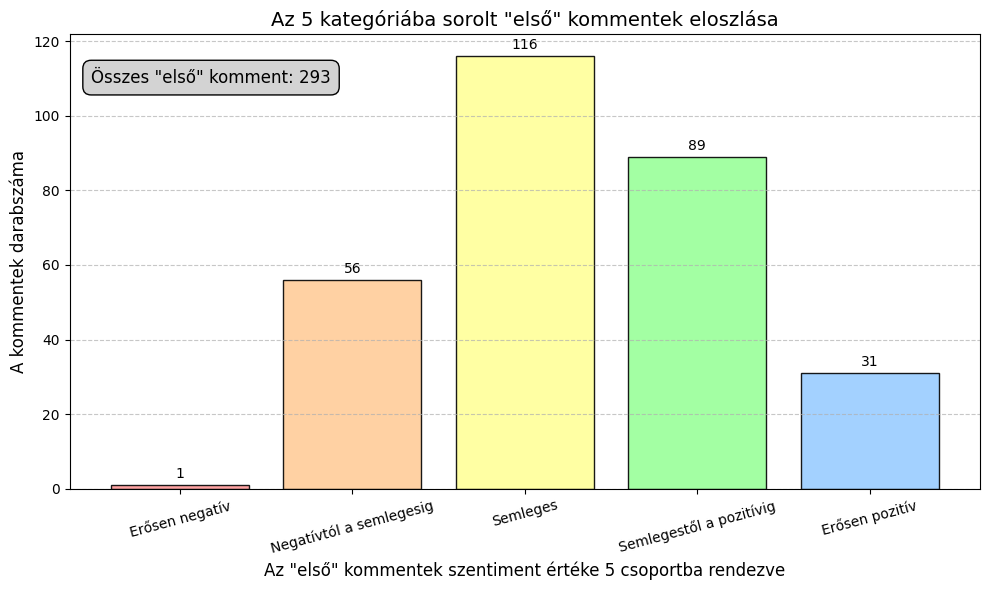

In [98]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract the first comment from each user
def extract_first_comments(comments, seen_users, first_comments):
    for comment in comments:
        commenter = comment.get("commenter")
        sentiment = comment.get("sentiment")
        
        # Check if the commenter is not already seen
        if commenter and commenter not in seen_users:
            seen_users.add(commenter)
            first_comments.append({"commenter": commenter, "sentiment": sentiment})
        
        # Recursively check replies
        replies = comment.get("replies", [])
        extract_first_comments(replies, seen_users, first_comments)

# Initialize data structures
seen_users = set()
first_comments = []

# Extract first comments
extract_first_comments(comments_data, seen_users, first_comments)

# Define the categories
categories = {
    "Erősen negatív": 0,
    "Negatívtól a semlegesig": 0,
    "Semleges": 0,
    "Semlegestől a pozitívig": 0,
    "Erősen pozitív": 0
}

# Classify the scores
for comment in first_comments:
    sentiment = comment.get("sentiment")
    if sentiment is not None:
        try:
            score = float(sentiment)  # Use the raw float without rounding
            if 1 <= score < 2:
                categories["Erősen negatív"] += 1
            elif 2 <= score < 5:
                categories["Negatívtól a semlegesig"] += 1
            elif 5 <= score <= 7:
                categories["Semleges"] += 1
            elif 7 < score <= 9:
                categories["Semlegestől a pozitívig"] += 1
            elif 9 < score <= 10:
                categories["Erősen pozitív"] += 1
        except ValueError:
            pass  # Skip if the sentiment cannot be converted to float


# Create a bar chart for the categories
labels = list(categories.keys())
values = list(categories.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['#ff9999', '#ffcc99', '#ffff99', '#99ff99', '#99ccff'], edgecolor='black', alpha=0.9)
plt.xlabel('Az \"első\" kommentek szentiment értéke 5 csoportba rendezve', fontsize=12)
plt.ylabel('A kommentek darabszáma', fontsize=12)
plt.title('Az 5 kategóriába sorolt \"első\" kommentek eloszlása', fontsize=14)
plt.xticks(rotation=15)

# Add total replies annotation
total_replies = sum(values)
plt.text(0.18, max(values) * 0.95, f'Összes \"első\" komment: {total_replies}', fontsize=12, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.savefig('Distribution_of_Sentiment_Scores_in_Five_Segments_first_comments_HUN.png')
plt.show()

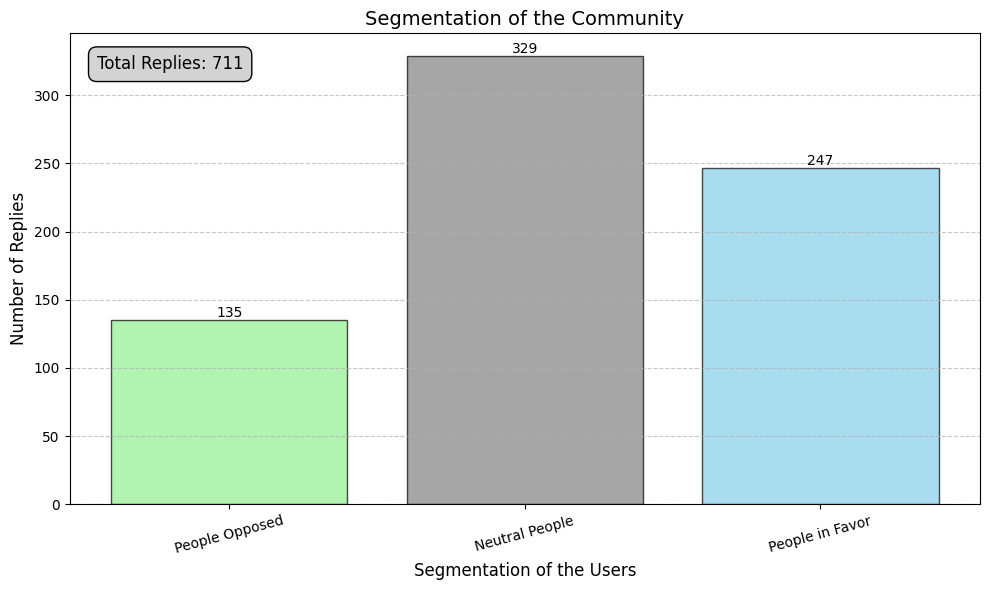

In [101]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Recursive function to extract sentiment scores from all levels
def extract_sentiment_scores(comments):
    scores = []
    for comment in comments:
        sentiment = comment.get("sentiment")
        if sentiment is not None:
            try:
                # Add the raw float score to the list
                scores.append(float(sentiment))
            except ValueError:
                pass  # Skip if the sentiment cannot be converted to float
        
        # Recursively extract scores from replies
        replies = comment.get("replies", [])
        scores.extend(extract_sentiment_scores(replies))
    
    return scores

# Extract all sentiment scores
sentiment_scores = extract_sentiment_scores(comments_data)

# Define the new categories
categories = {
    "People Opposed": 0,
    "Neutral People": 0,
    "People in Favor": 0
}

# Adjusted 3-segment code
for score in sentiment_scores:
    if 1 <= score < 5:      # Covers scores from 1 up to 4.99
        categories["People Opposed"] += 1
    elif 5 <= score <= 7:   # Covers scores from 5 up to 7 inclusive
        categories["Neutral People"] += 1
    elif 7 < score <= 10:   # Covers scores above 7 up to 10 inclusive
        categories["People in Favor"] += 1

# Create a bar chart for the categories
labels = list(categories.keys())
values = list(categories.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['lightgreen', 'gray', 'skyblue'], edgecolor='black', alpha=0.7)

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Segmentation of the Users', fontsize=12)
plt.ylabel('Number of Replies', fontsize=12)
plt.title('Segmentation of the Community', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total replies as a text annotation
total_replies = len(sentiment_scores)
plt.text(-0.2, max(values) * 0.97, f'Total Replies: {total_replies}', ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Show the plot
plt.tight_layout()
plt.savefig('Community_Sentiment_Segmentation.png')
plt.show()


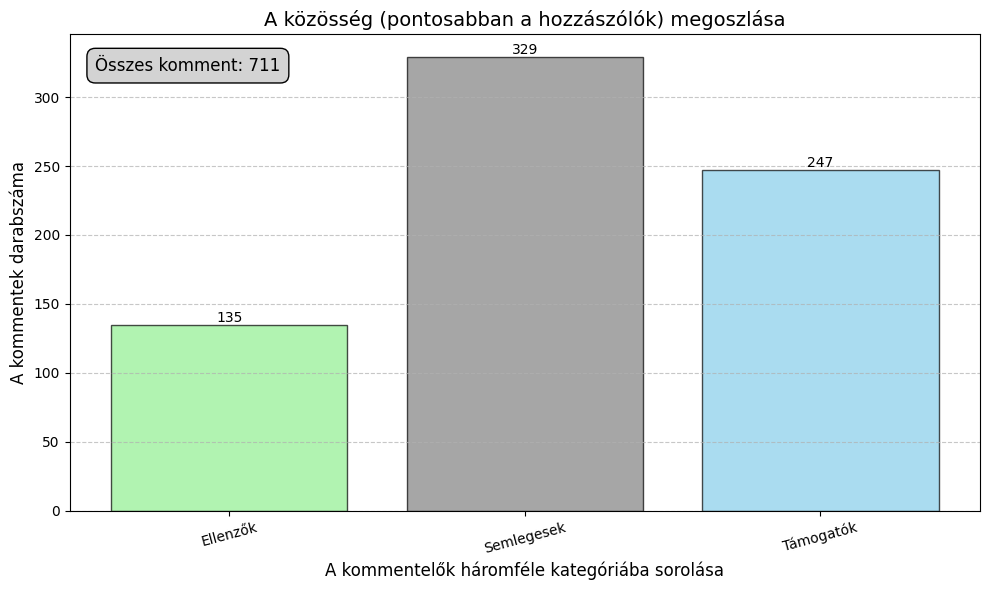

In [126]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Recursive function to extract sentiment scores from all levels
def extract_sentiment_scores(comments):
    scores = []
    for comment in comments:
        sentiment = comment.get("sentiment")
        if sentiment is not None:
            try:
                # Add the raw float score to the list
                scores.append(float(sentiment))
            except ValueError:
                pass  # Skip if the sentiment cannot be converted to float
        
        # Recursively extract scores from replies
        replies = comment.get("replies", [])
        scores.extend(extract_sentiment_scores(replies))
    
    return scores

# Extract all sentiment scores
sentiment_scores = extract_sentiment_scores(comments_data)

# Define the new categories
categories = {
    "Ellenzők": 0,
    "Semlegesek": 0,
    "Támogatók": 0
}

# Adjusted 3-segment code
for score in sentiment_scores:
    if 1 <= score < 5:      # Covers scores from 1 up to 4.99
        categories["Ellenzők"] += 1
    elif 5 <= score <= 7:   # Covers scores from 5 up to 7 inclusive
        categories["Semlegesek"] += 1
    elif 7 < score <= 10:   # Covers scores above 7 up to 10 inclusive
        categories["Támogatók"] += 1

# Create a bar chart for the categories
labels = list(categories.keys())
values = list(categories.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['lightgreen', 'gray', 'skyblue'], edgecolor='black', alpha=0.7)

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('A kommentelők háromféle kategóriába sorolása', fontsize=12)
plt.ylabel('A kommentek darabszáma', fontsize=12)
plt.title('A közösség (pontosabban a hozzászólók) megoszlása', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total replies as a text annotation
total_replies = len(sentiment_scores)
plt.text(-0.14, max(values) * 0.97, f'Összes komment: {total_replies}', ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Show the plot
plt.tight_layout()
plt.savefig('Community_Sentiment_Segmentation_HUN.png')
plt.show()


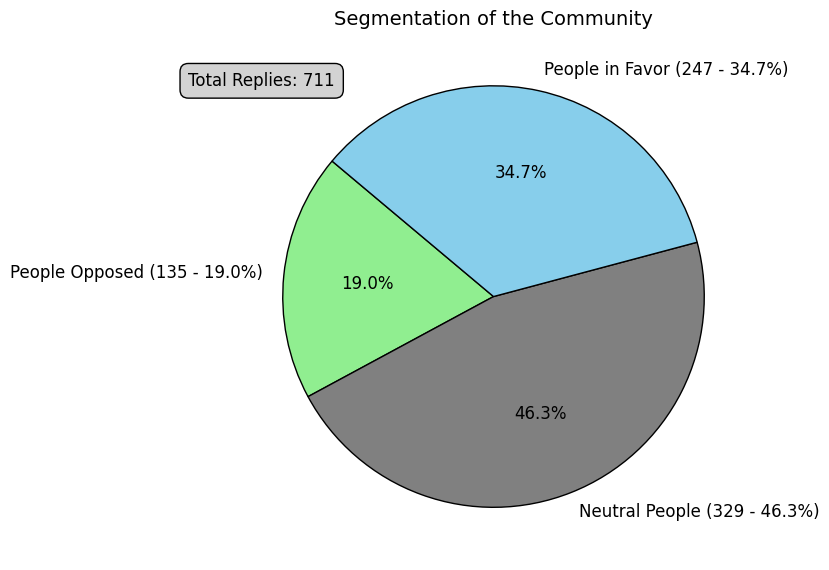

In [108]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Recursive function to extract sentiment scores from all levels
def extract_sentiment_scores(comments):
    scores = []
    for comment in comments:
        sentiment = comment.get("sentiment")
        if sentiment is not None:
            try:
                # Add the raw float score to the list
                scores.append(float(sentiment))
            except ValueError:
                pass  # Skip if the sentiment cannot be converted to float
        
        # Recursively extract scores from replies
        replies = comment.get("replies", [])
        scores.extend(extract_sentiment_scores(replies))
    
    return scores

# Extract all sentiment scores
sentiment_scores = extract_sentiment_scores(comments_data)

# Define the new categories
categories = {
    "People Opposed": 0,
    "Neutral People": 0,
    "People in Favor": 0
}

# Classify the scores into the new categories
for score in sentiment_scores:
    if 1.00 <= score <= 4.99:
        categories["People Opposed"] += 1
    elif 5.00 <= score <= 7.00:
        categories["Neutral People"] += 1
    elif 7.01 <= score <= 10.00:
        categories["People in Favor"] += 1

# Calculate the total replies for percentage calculation
total_replies = len(sentiment_scores)
labels = list(categories.keys())
sizes = list(categories.values())
colors = ['lightgreen', 'gray', 'skyblue']

# Prepare labels with counts and percentages
labels_with_percentages = [
    f"{label} ({size} - {size / total_replies:.1%})"
    for label, size in zip(labels, sizes)
]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, labels=labels_with_percentages, colors=colors, autopct='%1.1f%%',
    startangle=140, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12}
)
plt.title('Segmentation of the Community', fontsize=14)

# Display total replies annotation
plt.text(-1.1, 1, f'Total Replies: {total_replies}', ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

plt.tight_layout()
plt.savefig('Community_Sentiment_Segmentation_piechart.png')
plt.show()


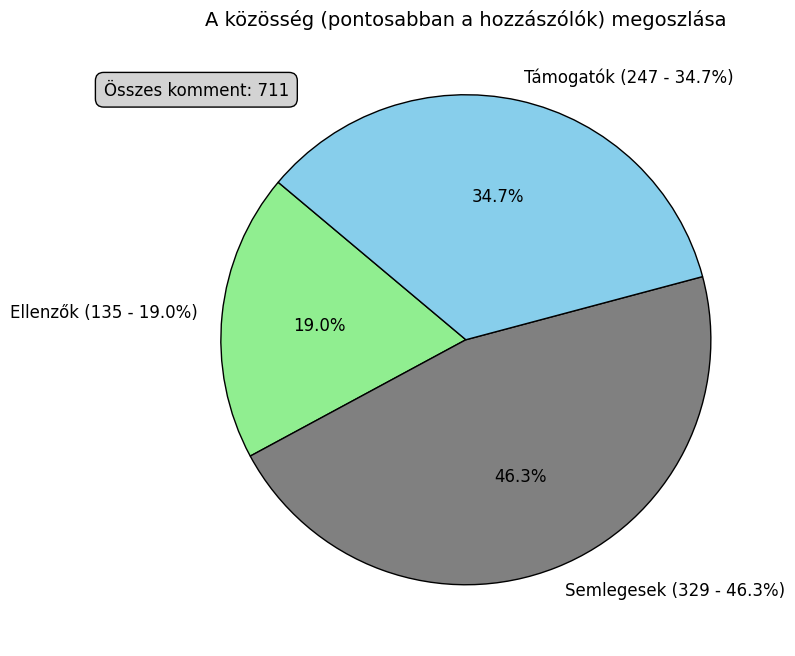

In [125]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Recursive function to extract sentiment scores from all levels
def extract_sentiment_scores(comments):
    scores = []
    for comment in comments:
        sentiment = comment.get("sentiment")
        if sentiment is not None:
            try:
                # Add the raw float score to the list
                scores.append(float(sentiment))
            except ValueError:
                pass  # Skip if the sentiment cannot be converted to float
        
        # Recursively extract scores from replies
        replies = comment.get("replies", [])
        scores.extend(extract_sentiment_scores(replies))
    
    return scores

# Extract all sentiment scores
sentiment_scores = extract_sentiment_scores(comments_data)

# Define the new categories
categories = {
    "Ellenzők": 0,
    "Semlegesek": 0,
    "Támogatók": 0
}

# Classify the scores into the new categories
for score in sentiment_scores:
    if 1.00 <= score <= 4.99:
        categories["Ellenzők"] += 1
    elif 5.00 <= score <= 7.00:
        categories["Semlegesek"] += 1
    elif 7.01 <= score <= 10.00:
        categories["Támogatók"] += 1

# Calculate the total replies for percentage calculation
total_replies = len(sentiment_scores)
labels = list(categories.keys())
sizes = list(categories.values())
colors = ['lightgreen', 'gray', 'skyblue']

# Prepare labels with counts and percentages
labels_with_percentages = [
    f"{label} ({size} - {size / total_replies:.1%})"
    for label, size in zip(labels, sizes)
]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, labels=labels_with_percentages, colors=colors, autopct='%1.1f%%',
    startangle=140, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12}
)
plt.title('A közösség (pontosabban a hozzászólók) megoszlása', fontsize=14)

# Display total replies annotation
plt.text(-1.1, 1, f'Összes komment: {total_replies}', ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

plt.tight_layout()
plt.savefig('Community_Sentiment_Segmentation_piechart_HUN.png')
plt.show()


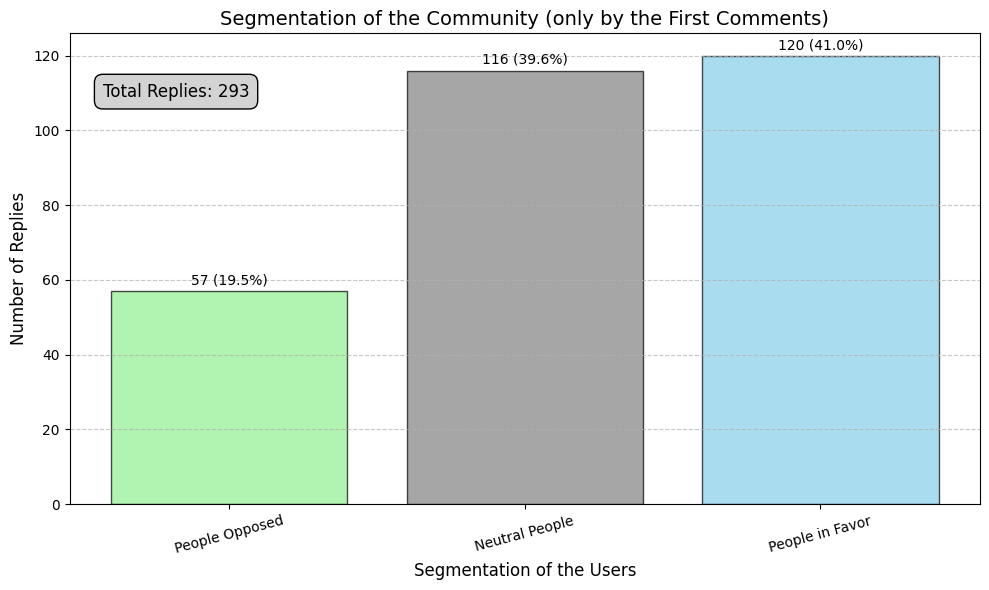

In [117]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract the first comment from each user
def extract_first_comments(comments, seen_users, first_comments):
    for comment in comments:
        commenter = comment.get("commenter")
        sentiment = comment.get("sentiment")
        
        # Check if the commenter is not already seen
        if commenter and commenter not in seen_users:
            seen_users.add(commenter)
            first_comments.append({"commenter": commenter, "sentiment": sentiment})
        
        # Recursively check replies
        replies = comment.get("replies", [])
        extract_first_comments(replies, seen_users, first_comments)

# Initialize data structures
seen_users = set()
first_comments = []

# Extract first comments
extract_first_comments(comments_data, seen_users, first_comments)

# Define the segments
segments = {
    "People Opposed": 0,  # 1.00 - 4.99
    "Neutral People": 0,     # 5.00 - 7.00
    "People in Favor": 0       # 7.01 - 10.00
}

# Classify the scores
for comment in first_comments:
    sentiment = comment.get("sentiment")
    if sentiment is not None:
        try:
            score = float(sentiment)
            if 1.00 <= score < 5.00:
                segments["People Opposed"] += 1
            elif 5.00 <= score <= 7.00:
                segments["Neutral People"] += 1
            elif 7.01 <= score <= 10.00:
                segments["People in Favor"] += 1
        except ValueError:
            pass  # Skip if the sentiment cannot be converted to float

# Create a bar chart for the segments
labels = list(segments.keys())
values = list(segments.values())

# Calculate percentages
total_comments = sum(values)
percentages = [(value / total_comments) * 100 if total_comments > 0 else 0 for value in values]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['lightgreen', 'gray', 'skyblue'], edgecolor='black', alpha=0.7)

# Add total numbers and percentages on top of each bar
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval} ({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.xlabel('Segmentation of the Users', fontsize=12)
plt.ylabel('Number of Replies', fontsize=12)
plt.title('Segmentation of the Community (only by the First Comments)', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total comments annotation
plt.text(-0.18, max(values) * 0.92, f'Total Replies: {total_comments}', fontsize=12, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Show the plot
plt.tight_layout()
plt.savefig('Community_Sentiment_Segmentation_first_comments.png')
plt.show()


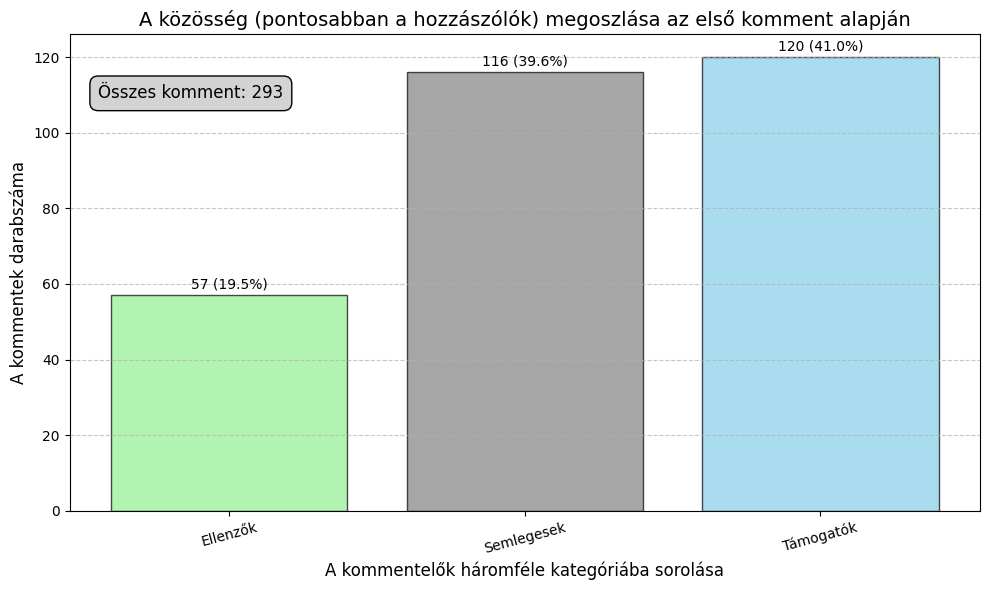

In [121]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract the first comment from each user
def extract_first_comments(comments, seen_users, first_comments):
    for comment in comments:
        commenter = comment.get("commenter")
        sentiment = comment.get("sentiment")
        
        # Check if the commenter is not already seen
        if commenter and commenter not in seen_users:
            seen_users.add(commenter)
            first_comments.append({"commenter": commenter, "sentiment": sentiment})
        
        # Recursively check replies
        replies = comment.get("replies", [])
        extract_first_comments(replies, seen_users, first_comments)

# Initialize data structures
seen_users = set()
first_comments = []

# Extract first comments
extract_first_comments(comments_data, seen_users, first_comments)

# Define the segments
segments = {
    "Ellenzők": 0,  # 1.00 - 4.99
    "Semlegesek": 0,     # 5.00 - 7.00
    "Támogatók": 0       # 7.01 - 10.00
}

# Classify the scores
for comment in first_comments:
    sentiment = comment.get("sentiment")
    if sentiment is not None:
        try:
            score = float(sentiment)
            if 1.00 <= score < 5.00:
                segments["Ellenzők"] += 1
            elif 5.00 <= score <= 7.00:
                segments["Semlegesek"] += 1
            elif 7.01 <= score <= 10.00:
                segments["Támogatók"] += 1
        except ValueError:
            pass  # Skip if the sentiment cannot be converted to float

# Create a bar chart for the segments
labels = list(segments.keys())
values = list(segments.values())

# Calculate percentages
total_comments = sum(values)
percentages = [(value / total_comments) * 100 if total_comments > 0 else 0 for value in values]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['lightgreen', 'gray', 'skyblue'], edgecolor='black', alpha=0.7)

# Add total numbers and percentages on top of each bar
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval} ({percentage:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.xlabel('A kommentelők háromféle kategóriába sorolása', fontsize=12)
plt.ylabel('A kommentek darabszáma', fontsize=12)
plt.title('A közösség (pontosabban a hozzászólók) megoszlása az első komment alapján', fontsize=14)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add total comments annotation
plt.text(-0.13, max(values) * 0.92, f'Összes komment: {total_comments}', fontsize=12, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

# Show the plot
plt.tight_layout()
plt.savefig('Community_Sentiment_Segmentation_first_comments_HUN.png')
plt.show()


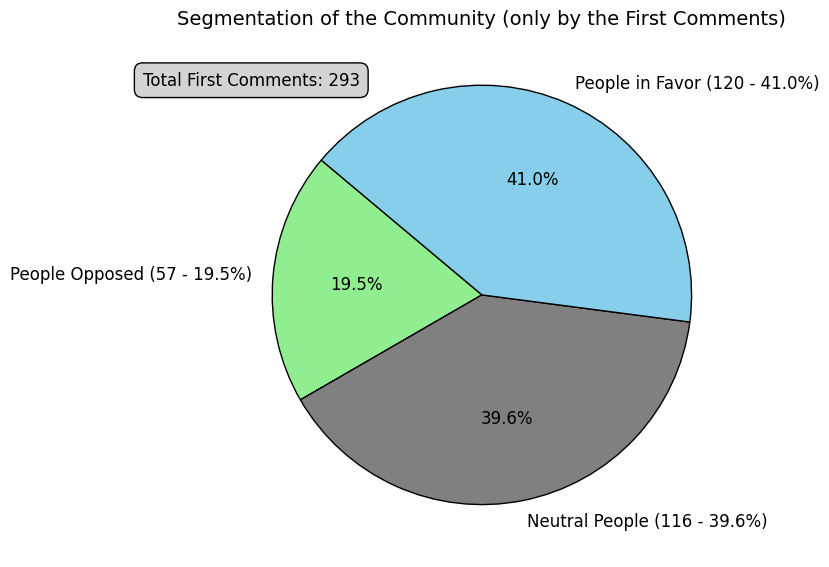

In [122]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract the first comment from each user
def extract_first_comments(comments, seen_users, first_comments):
    for comment in comments:
        commenter = comment.get("commenter")
        sentiment = comment.get("sentiment")
        
        # Check if the commenter is not already seen
        if commenter and commenter not in seen_users:
            seen_users.add(commenter)
            first_comments.append({"commenter": commenter, "sentiment": sentiment})
        
        # Recursively check replies
        replies = comment.get("replies", [])
        extract_first_comments(replies, seen_users, first_comments)

# Initialize data structures
seen_users = set()
first_comments = []

# Extract first comments
extract_first_comments(comments_data, seen_users, first_comments)

# Define the new categories for community segmentation
categories = {
    "People Opposed": 0,
    "Neutral People": 0,
    "People in Favor": 0
}

# Classify the scores into the new segments
for comment in first_comments:
    sentiment = comment.get("sentiment")
    if sentiment is not None:
        try:
            score = float(sentiment)
            if 1.00 <= score <= 4.99:
                categories["People Opposed"] += 1
            elif 5.00 <= score <= 7.00:
                categories["Neutral People"] += 1
            elif 7.01 <= score <= 10.00:
                categories["People in Favor"] += 1
        except ValueError:
            pass  # Skip if the sentiment cannot be converted to float

# Calculate the total replies for percentage calculation
total_replies = sum(categories.values())
labels = list(categories.keys())
sizes = list(categories.values())
colors = ['lightgreen', 'gray', 'skyblue']

# Prepare labels with counts and percentages
labels_with_percentages = [
    f"{label} ({size} - {size / total_replies:.1%})"
    for label, size in zip(labels, sizes)
]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, labels=labels_with_percentages, colors=colors, autopct='%1.1f%%',
    startangle=140, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12}
)
plt.title('Segmentation of the Community (only by the First Comments)', fontsize=14)

# Display total replies annotation
plt.text(-1.1, 1, f'Total First Comments: {total_replies}', ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

plt.tight_layout()
plt.savefig('Community_Sentiment_Segmentation_first_comments_piechart.png')
plt.show()


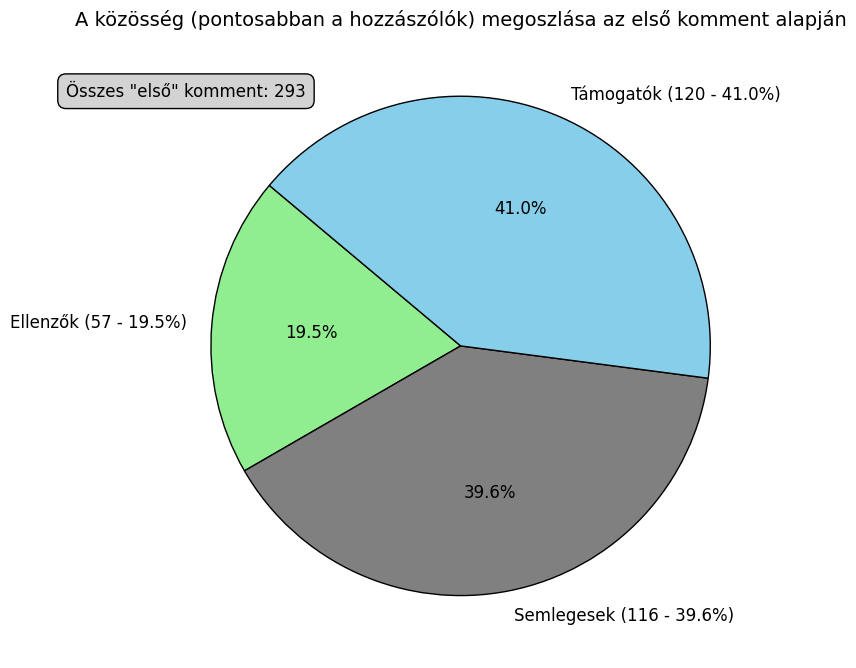

In [124]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract the first comment from each user
def extract_first_comments(comments, seen_users, first_comments):
    for comment in comments:
        commenter = comment.get("commenter")
        sentiment = comment.get("sentiment")
        
        # Check if the commenter is not already seen
        if commenter and commenter not in seen_users:
            seen_users.add(commenter)
            first_comments.append({"commenter": commenter, "sentiment": sentiment})
        
        # Recursively check replies
        replies = comment.get("replies", [])
        extract_first_comments(replies, seen_users, first_comments)

# Initialize data structures
seen_users = set()
first_comments = []

# Extract first comments
extract_first_comments(comments_data, seen_users, first_comments)

# Define the new categories for community segmentation
categories = {
    "Ellenzők": 0,
    "Semlegesek": 0,
    "Támogatók": 0
}

# Classify the scores into the new segments
for comment in first_comments:
    sentiment = comment.get("sentiment")
    if sentiment is not None:
        try:
            score = float(sentiment)
            if 1.00 <= score <= 4.99:
                categories["Ellenzők"] += 1
            elif 5.00 <= score <= 7.00:
                categories["Semlegesek"] += 1
            elif 7.01 <= score <= 10.00:
                categories["Támogatók"] += 1
        except ValueError:
            pass  # Skip if the sentiment cannot be converted to float

# Calculate the total replies for percentage calculation
total_replies = sum(categories.values())
labels = list(categories.keys())
sizes = list(categories.values())
colors = ['lightgreen', 'gray', 'skyblue']

# Prepare labels with counts and percentages
labels_with_percentages = [
    f"{label} ({size} - {size / total_replies:.1%})"
    for label, size in zip(labels, sizes)
]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, labels=labels_with_percentages, colors=colors, autopct='%1.1f%%',
    startangle=140, wedgeprops={'edgecolor': 'black'}, textprops={'fontsize': 12}
)
plt.title('A közösség (pontosabban a hozzászólók) megoszlása az első komment alapján', fontsize=14)

# Display total replies annotation
plt.text(-1.1, 1, f'Összes \"első\" komment: {total_replies}', ha='center', fontsize=12, bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

plt.tight_layout()
plt.savefig('Community_Sentiment_Segmentation_first_comments_piechart_HUN.png')
plt.show()


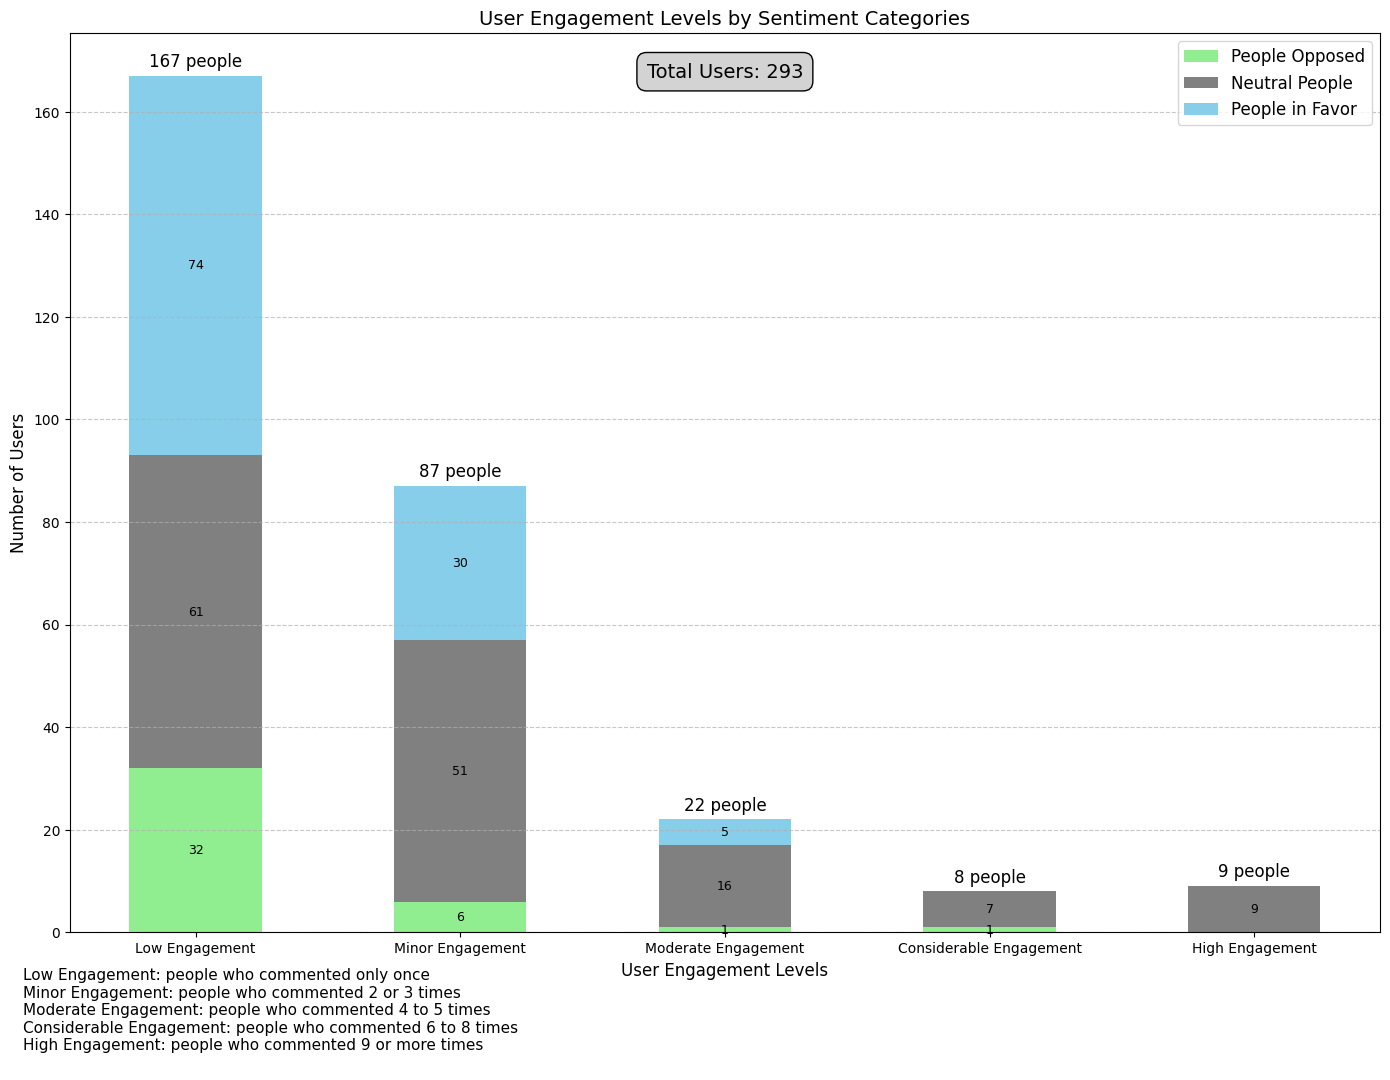

In [157]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract user engagement data
def extract_user_engagement(comments):
    user_comments = {}

    # Recursive function to count comments for each user
    def count_comments(comments):
        for comment in comments:
            commenter = comment.get("commenter")
            sentiment = comment.get("sentiment")

            # Initialize user's comment count and sentiment score
            if commenter not in user_comments:
                user_comments[commenter] = {"count": 0, "sentiment_scores": []}

            # Update the user's comment count and add sentiment score
            user_comments[commenter]["count"] += 1
            if sentiment is not None:
                try:
                    user_comments[commenter]["sentiment_scores"].append(float(sentiment))
                except ValueError:
                    pass  # Skip if sentiment cannot be converted

            # Recursively count replies
            replies = comment.get("replies", [])
            count_comments(replies)

    count_comments(comments)
    return user_comments

# Get user engagement data
user_comments = extract_user_engagement(comments_data)

# Define engagement levels
engagement_levels = {
    "Low Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Minor Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Moderate Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Considerable Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "High Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0}
}

# Categorize users based on engagement and sentiment
for user, data in user_comments.items():
    count = data["count"]
    sentiment_scores = data["sentiment_scores"]

    # Determine engagement level
    if count == 1:
        engagement_levels["Low Engagement"]["total"] += 1
    elif 2 <= count <= 3:
        engagement_levels["Minor Engagement"]["total"] += 1
    elif 4 <= count <= 5:
        engagement_levels["Moderate Engagement"]["total"] += 1
    elif 6 <= count <= 8:
        engagement_levels["Considerable Engagement"]["total"] += 1
    elif count >= 9:
        engagement_levels["High Engagement"]["total"] += 1

    # Calculate average sentiment score
    if sentiment_scores:
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        # Determine sentiment category
        if average_sentiment < 5.00:
            engagement_levels["Low Engagement"]["People Against It"] += 1 if count == 1 else 0
            engagement_levels["Minor Engagement"]["People Against It"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Moderate Engagement"]["People Against It"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Considerable Engagement"]["People Against It"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["High Engagement"]["People Against It"] += 1 if count >= 9 else 0
        elif 5.00 <= average_sentiment <= 7.00:
            engagement_levels["Low Engagement"]["Neutral People"] += 1 if count == 1 else 0
            engagement_levels["Minor Engagement"]["Neutral People"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Moderate Engagement"]["Neutral People"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Considerable Engagement"]["Neutral People"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["High Engagement"]["Neutral People"] += 1 if count >= 9 else 0
        else:
            engagement_levels["Low Engagement"]["People For It"] += 1 if count == 1 else 0
            engagement_levels["Minor Engagement"]["People For It"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Moderate Engagement"]["People For It"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Considerable Engagement"]["People For It"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["High Engagement"]["People For It"] += 1 if count >= 9 else 0

# Prepare data for plotting
engagement_labels = list(engagement_levels.keys())
total_counts = [engagement_levels[level]["total"] for level in engagement_labels]
against_counts = [engagement_levels[level]["People Against It"] for level in engagement_labels]
neutral_counts = [engagement_levels[level]["Neutral People"] for level in engagement_labels]
for_counts = [engagement_levels[level]["People For It"] for level in engagement_labels]

# Plotting the data
bar_width = 0.5
index = np.arange(len(engagement_labels))

plt.figure(figsize=(14, 10))
bar1 = plt.bar(index, against_counts, bar_width, label='People Opposed', color='lightgreen')
bar2 = plt.bar(index, neutral_counts, bar_width, bottom=against_counts, label='Neutral People', color='gray')
bar3 = plt.bar(index, for_counts, bar_width, bottom=np.array(against_counts) + np.array(neutral_counts), label='People in Favor', color='skyblue')

# Show data labels for each category within the stacked bars
for i in range(len(index)):
    # Calculate heights for each segment within the stacked bar
    height_against = against_counts[i]
    height_neutral = neutral_counts[i]
    height_for = for_counts[i]

    # Display counts for each category within each bar
    if height_against > 0:
        plt.text(index[i], height_against / 2, f"{height_against}", ha='center', va='center', fontsize=9, color='black')
    if height_neutral > 0:
        plt.text(index[i], height_against + (height_neutral / 2), f"{height_neutral}", ha='center', va='center', fontsize=9, color='black')
    if height_for > 0:
        plt.text(index[i], height_against + height_neutral + (height_for / 2), f"{height_for}", ha='center', va='center', fontsize=9, color='black')

# Adding labels and title
plt.xlabel('User Engagement Levels', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('User Engagement Levels by Sentiment Categories', fontsize=14)
plt.xticks(index, engagement_labels)

# Show legend-like explanation as a note
note = """
Low Engagement: people who commented only once
Minor Engagement: people who commented 2 or 3 times
Moderate Engagement: people who commented 4 to 5 times
Considerable Engagement: people who commented 6 to 8 times
High Engagement: people who commented 9 or more times
"""
plt.figtext(0.02, -0.07, note, ha="left", fontsize=11, wrap=True)

plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show data labels on top of each segment
for i in range(len(index)):
    total_height = total_counts[i]
    plt.text(index[i], total_height + 1, f"{total_height} people", ha='center', va='bottom', fontsize=12)

# Add total comments annotation
plt.text((len(index) - 1) / 2, max(values) * 0.51, f'Total Users: {total_comments}', fontsize=14, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

plt.tight_layout()
plt.savefig('User_Engagement_Segmentation.png')
plt.show()


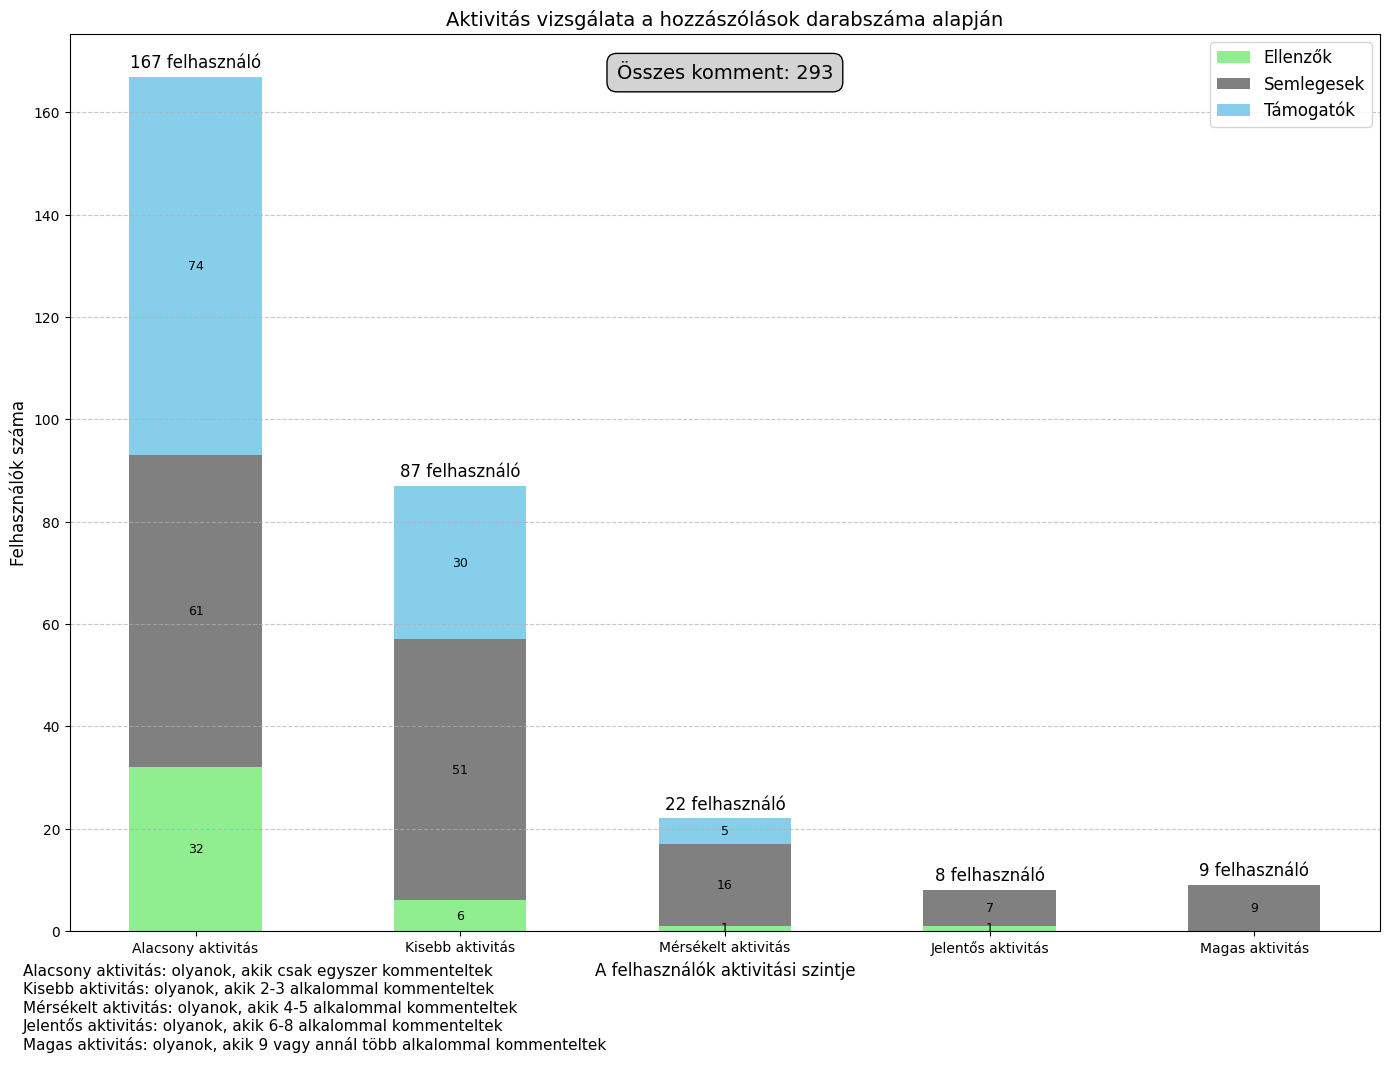

In [160]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract user engagement data
def extract_user_engagement(comments):
    user_comments = {}

    # Recursive function to count comments for each user
    def count_comments(comments):
        for comment in comments:
            commenter = comment.get("commenter")
            sentiment = comment.get("sentiment")

            # Initialize user's comment count and sentiment score
            if commenter not in user_comments:
                user_comments[commenter] = {"count": 0, "sentiment_scores": []}

            # Update the user's comment count and add sentiment score
            user_comments[commenter]["count"] += 1
            if sentiment is not None:
                try:
                    user_comments[commenter]["sentiment_scores"].append(float(sentiment))
                except ValueError:
                    pass  # Skip if sentiment cannot be converted

            # Recursively count replies
            replies = comment.get("replies", [])
            count_comments(replies)

    count_comments(comments)
    return user_comments

# Get user engagement data
user_comments = extract_user_engagement(comments_data)

# Define engagement levels
engagement_levels = {
    "Alacsony aktivitás": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Kisebb aktivitás": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Mérsékelt aktivitás": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Jelentős aktivitás": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Magas aktivitás": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0}
}

# Categorize users based on engagement and sentiment
for user, data in user_comments.items():
    count = data["count"]
    sentiment_scores = data["sentiment_scores"]

    # Determine engagement level
    if count == 1:
        engagement_levels["Alacsony aktivitás"]["total"] += 1
    elif 2 <= count <= 3:
        engagement_levels["Kisebb aktivitás"]["total"] += 1
    elif 4 <= count <= 5:
        engagement_levels["Mérsékelt aktivitás"]["total"] += 1
    elif 6 <= count <= 8:
        engagement_levels["Jelentős aktivitás"]["total"] += 1
    elif count >= 9:
        engagement_levels["Magas aktivitás"]["total"] += 1

    # Calculate average sentiment score
    if sentiment_scores:
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        # Determine sentiment category
        if average_sentiment < 5.00:
            engagement_levels["Alacsony aktivitás"]["People Against It"] += 1 if count == 1 else 0
            engagement_levels["Kisebb aktivitás"]["People Against It"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Mérsékelt aktivitás"]["People Against It"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Jelentős aktivitás"]["People Against It"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["Magas aktivitás"]["People Against It"] += 1 if count >= 9 else 0
        elif 5.00 <= average_sentiment <= 7.00:
            engagement_levels["Alacsony aktivitás"]["Neutral People"] += 1 if count == 1 else 0
            engagement_levels["Kisebb aktivitás"]["Neutral People"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Mérsékelt aktivitás"]["Neutral People"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Jelentős aktivitás"]["Neutral People"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["Magas aktivitás"]["Neutral People"] += 1 if count >= 9 else 0
        else:
            engagement_levels["Alacsony aktivitás"]["People For It"] += 1 if count == 1 else 0
            engagement_levels["Kisebb aktivitás"]["People For It"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Mérsékelt aktivitás"]["People For It"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Jelentős aktivitás"]["People For It"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["Magas aktivitás"]["People For It"] += 1 if count >= 9 else 0

# Prepare data for plotting
engagement_labels = list(engagement_levels.keys())
total_counts = [engagement_levels[level]["total"] for level in engagement_labels]
against_counts = [engagement_levels[level]["People Against It"] for level in engagement_labels]
neutral_counts = [engagement_levels[level]["Neutral People"] for level in engagement_labels]
for_counts = [engagement_levels[level]["People For It"] for level in engagement_labels]

# Plotting the data
bar_width = 0.5
index = np.arange(len(engagement_labels))

plt.figure(figsize=(14, 10))
bar1 = plt.bar(index, against_counts, bar_width, label='Ellenzők', color='lightgreen')
bar2 = plt.bar(index, neutral_counts, bar_width, bottom=against_counts, label='Semlegesek', color='gray')
bar3 = plt.bar(index, for_counts, bar_width, bottom=np.array(against_counts) + np.array(neutral_counts), label='Támogatók', color='skyblue')

# Show data labels for each category within the stacked bars
for i in range(len(index)):
    # Calculate heights for each segment within the stacked bar
    height_against = against_counts[i]
    height_neutral = neutral_counts[i]
    height_for = for_counts[i]

    # Display counts for each category within each bar
    if height_against > 0:
        plt.text(index[i], height_against / 2, f"{height_against}", ha='center', va='center', fontsize=9, color='black')
    if height_neutral > 0:
        plt.text(index[i], height_against + (height_neutral / 2), f"{height_neutral}", ha='center', va='center', fontsize=9, color='black')
    if height_for > 0:
        plt.text(index[i], height_against + height_neutral + (height_for / 2), f"{height_for}", ha='center', va='center', fontsize=9, color='black')

# Adding labels and title
plt.xlabel('A felhasználók aktivitási szintje', fontsize=12)
plt.ylabel('Felhasználók száma', fontsize=12)
plt.title('Aktivitás vizsgálata a hozzászólások darabszáma alapján', fontsize=14)
plt.xticks(index, engagement_labels)

# Show legend-like explanation as a note
note = """
Alacsony aktivitás: olyanok, akik csak egyszer kommenteltek
Kisebb aktivitás: olyanok, akik 2-3 alkalommal kommenteltek
Mérsékelt aktivitás: olyanok, akik 4-5 alkalommal kommenteltek
Jelentős aktivitás: olyanok, akik 6-8 alkalommal kommenteltek
Magas aktivitás: olyanok, akik 9 vagy annál több alkalommal kommenteltek
"""
plt.figtext(0.02, -0.07, note, ha="left", fontsize=11, wrap=True)

plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show data labels on top of each segment
for i in range(len(index)):
    total_height = total_counts[i]
    plt.text(index[i], total_height + 1, f"{total_height} felhasználó", ha='center', va='bottom', fontsize=12)

# Add total comments annotation
plt.text((len(index) - 1) / 2, max(values) * 0.51, f'Összes komment: {total_comments}', fontsize=14, ha='center', va='center', bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightgray'))

plt.tight_layout()
plt.savefig('User_Engagement_Segmentation_HUN.png')
plt.show()


## trials and errors

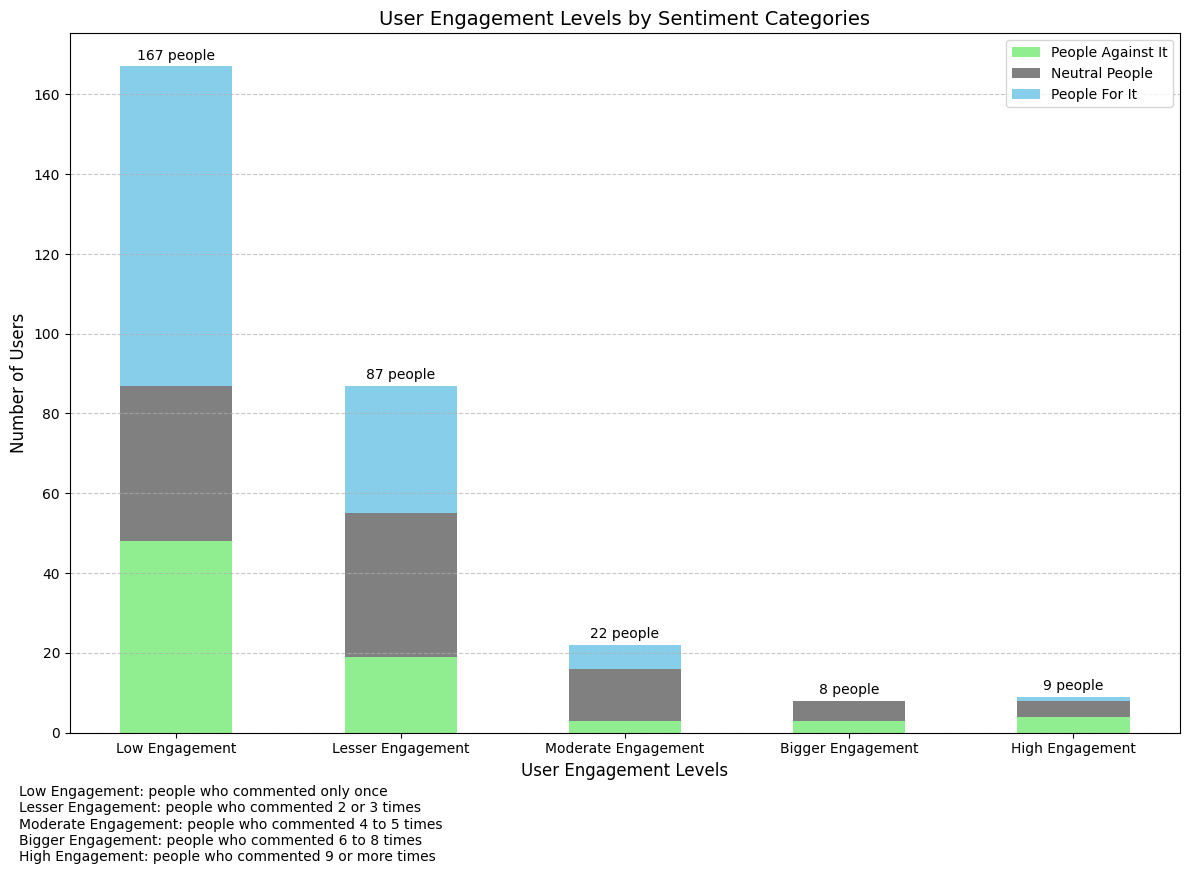

In [77]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract user engagement data
def extract_user_engagement(comments):
    user_comments = {}

    # Recursive function to count comments for each user
    def count_comments(comments):
        for comment in comments:
            commenter = comment.get("commenter")
            sentiment = comment.get("sentiment")

            # Initialize user's comment count and sentiment score
            if commenter not in user_comments:
                user_comments[commenter] = {"count": 0, "sentiment_scores": []}

            # Update the user's comment count and add sentiment score
            user_comments[commenter]["count"] += 1
            if sentiment is not None:
                try:
                    user_comments[commenter]["sentiment_scores"].append(float(sentiment))
                except ValueError:
                    pass  # Skip if sentiment cannot be converted

            # Recursively count replies
            replies = comment.get("replies", [])
            count_comments(replies)

    count_comments(comments)
    return user_comments

# Get user engagement data
user_comments = extract_user_engagement(comments_data)

# Define engagement levels
engagement_levels = {
    "Low Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Lesser Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Moderate Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Bigger Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "High Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0}
}

# Categorize users based on engagement and sentiment
for user, data in user_comments.items():
    count = data["count"]
    sentiment_scores = data["sentiment_scores"]

    # Determine engagement level
    if count == 1:
        engagement_levels["Low Engagement"]["total"] += 1
    elif 2 <= count <= 3:
        engagement_levels["Lesser Engagement"]["total"] += 1
    elif 4 <= count <= 5:
        engagement_levels["Moderate Engagement"]["total"] += 1
    elif 6 <= count <= 8:
        engagement_levels["Bigger Engagement"]["total"] += 1
    elif count >= 9:
        engagement_levels["High Engagement"]["total"] += 1

    # Calculate average sentiment score
    if sentiment_scores:
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        # Determine sentiment category
        if average_sentiment < 5.00:
            engagement_levels["Low Engagement"]["People Against It"] += 1 if count == 1 else 0
            engagement_levels["Lesser Engagement"]["People Against It"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Moderate Engagement"]["People Against It"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Bigger Engagement"]["People Against It"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["High Engagement"]["People Against It"] += 1 if count >= 9 else 0
        elif 5.00 <= average_sentiment <= 7.00:
            engagement_levels["Low Engagement"]["Neutral People"] += 1 if count == 1 else 0
            engagement_levels["Lesser Engagement"]["Neutral People"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Moderate Engagement"]["Neutral People"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Bigger Engagement"]["Neutral People"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["High Engagement"]["Neutral People"] += 1 if count >= 9 else 0
        else:
            engagement_levels["Low Engagement"]["People For It"] += 1 if count == 1 else 0
            engagement_levels["Lesser Engagement"]["People For It"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Moderate Engagement"]["People For It"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Bigger Engagement"]["People For It"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["High Engagement"]["People For It"] += 1 if count >= 9 else 0

# Prepare data for plotting
engagement_labels = list(engagement_levels.keys())
total_counts = [engagement_levels[level]["total"] for level in engagement_labels]
against_counts = [engagement_levels[level]["People Against It"] for level in engagement_labels]
neutral_counts = [engagement_levels[level]["Neutral People"] for level in engagement_labels]
for_counts = [engagement_levels[level]["People For It"] for level in engagement_labels]

# Plotting the data
bar_width = 0.5
index = np.arange(len(engagement_labels))

plt.figure(figsize=(12, 8))
bar1 = plt.bar(index, against_counts, bar_width, label='People Against It', color='lightgreen')
bar2 = plt.bar(index, neutral_counts, bar_width, bottom=against_counts, label='Neutral People', color='gray')
bar3 = plt.bar(index, for_counts, bar_width, bottom=np.array(against_counts) + np.array(neutral_counts), label='People For It', color='skyblue')

# Adding labels and title
plt.xlabel('User Engagement Levels', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('User Engagement Levels by Sentiment Categories', fontsize=14)
plt.xticks(index, engagement_labels)

# Show legend-like explanation as a note
note = """
Low Engagement: people who commented only once
Lesser Engagement: people who commented 2 or 3 times
Moderate Engagement: people who commented 4 to 5 times
Bigger Engagement: people who commented 6 to 8 times
High Engagement: people who commented 9 or more times
"""
plt.figtext(0.02, -0.1, note, ha="left", fontsize=10, wrap=True)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show data labels on top of each segment
for i in range(len(index)):
    total_height = total_counts[i]
    plt.text(index[i], total_height + 1, f"{total_height} people", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


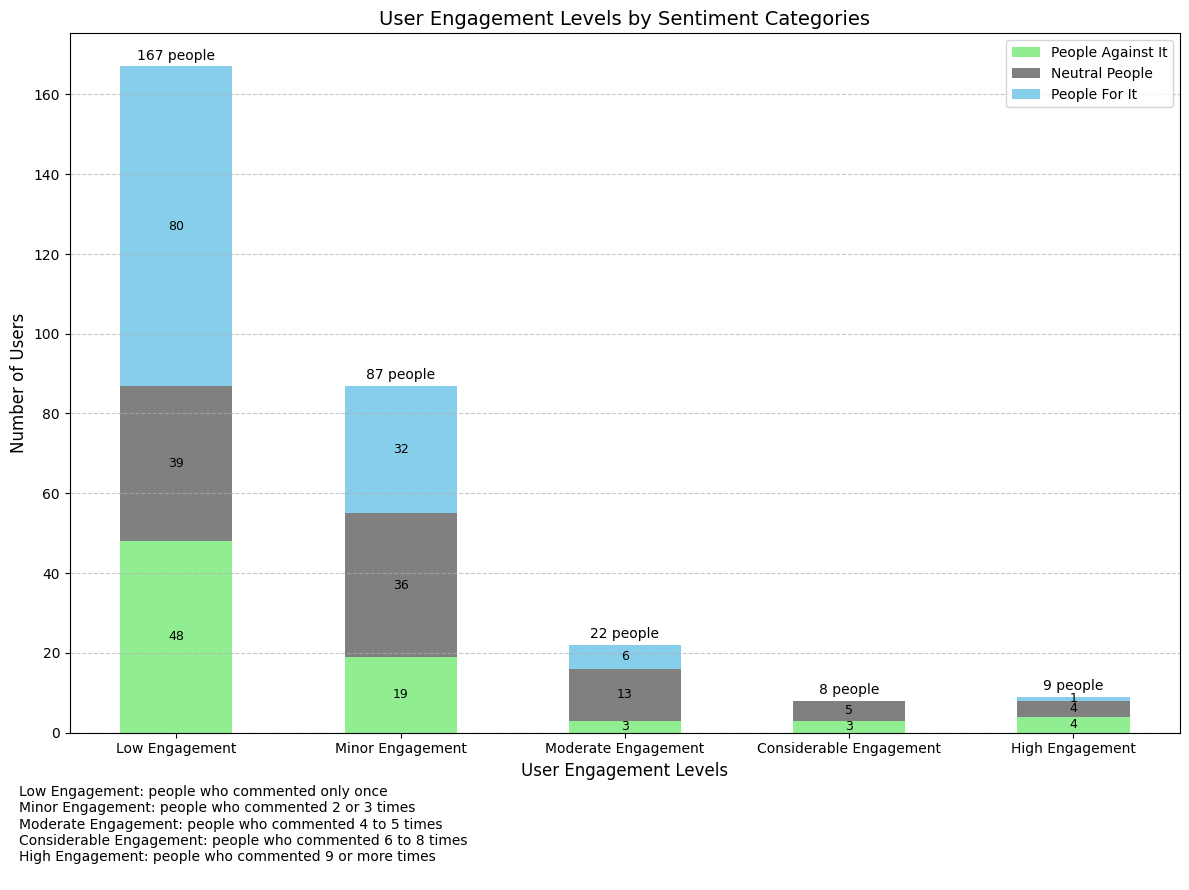

In [82]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data
with open("anonymized_comments_with_average_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to extract user engagement data
def extract_user_engagement(comments):
    user_comments = {}

    # Recursive function to count comments for each user
    def count_comments(comments):
        for comment in comments:
            commenter = comment.get("commenter")
            sentiment = comment.get("sentiment")

            # Initialize user's comment count and sentiment score
            if commenter not in user_comments:
                user_comments[commenter] = {"count": 0, "sentiment_scores": []}

            # Update the user's comment count and add sentiment score
            user_comments[commenter]["count"] += 1
            if sentiment is not None:
                try:
                    user_comments[commenter]["sentiment_scores"].append(float(sentiment))
                except ValueError:
                    pass  # Skip if sentiment cannot be converted

            # Recursively count replies
            replies = comment.get("replies", [])
            count_comments(replies)

    count_comments(comments)
    return user_comments

# Get user engagement data
user_comments = extract_user_engagement(comments_data)

# Define engagement levels
engagement_levels = {
    "Low Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Minor Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Moderate Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "Considerable Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0},
    "High Engagement": {"total": 0, "People Against It": 0, "Neutral People": 0, "People For It": 0}
}

# Categorize users based on engagement and sentiment
for user, data in user_comments.items():
    count = data["count"]
    sentiment_scores = data["sentiment_scores"]

    # Determine engagement level
    if count == 1:
        engagement_levels["Low Engagement"]["total"] += 1
    elif 2 <= count <= 3:
        engagement_levels["Minor Engagement"]["total"] += 1
    elif 4 <= count <= 5:
        engagement_levels["Moderate Engagement"]["total"] += 1
    elif 6 <= count <= 8:
        engagement_levels["Considerable Engagement"]["total"] += 1
    elif count >= 9:
        engagement_levels["High Engagement"]["total"] += 1

    # Calculate average sentiment score
    if sentiment_scores:
        average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        # Determine sentiment category
        if average_sentiment < 5.00:
            engagement_levels["Low Engagement"]["People Against It"] += 1 if count == 1 else 0
            engagement_levels["Minor Engagement"]["People Against It"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Moderate Engagement"]["People Against It"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Considerable Engagement"]["People Against It"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["High Engagement"]["People Against It"] += 1 if count >= 9 else 0
        elif 5.00 <= average_sentiment <= 7.00:
            engagement_levels["Low Engagement"]["Neutral People"] += 1 if count == 1 else 0
            engagement_levels["Minor Engagement"]["Neutral People"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Moderate Engagement"]["Neutral People"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Considerable Engagement"]["Neutral People"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["High Engagement"]["Neutral People"] += 1 if count >= 9 else 0
        else:
            engagement_levels["Low Engagement"]["People For It"] += 1 if count == 1 else 0
            engagement_levels["Minor Engagement"]["People For It"] += 1 if 2 <= count <= 3 else 0
            engagement_levels["Moderate Engagement"]["People For It"] += 1 if 4 <= count <= 5 else 0
            engagement_levels["Considerable Engagement"]["People For It"] += 1 if 6 <= count <= 8 else 0
            engagement_levels["High Engagement"]["People For It"] += 1 if count >= 9 else 0

# Prepare data for plotting
engagement_labels = list(engagement_levels.keys())
total_counts = [engagement_levels[level]["total"] for level in engagement_labels]
against_counts = [engagement_levels[level]["People Against It"] for level in engagement_labels]
neutral_counts = [engagement_levels[level]["Neutral People"] for level in engagement_labels]
for_counts = [engagement_levels[level]["People For It"] for level in engagement_labels]

# Plotting the data
bar_width = 0.5
index = np.arange(len(engagement_labels))

plt.figure(figsize=(12, 8))
bar1 = plt.bar(index, against_counts, bar_width, label='People Against It', color='lightgreen')
bar2 = plt.bar(index, neutral_counts, bar_width, bottom=against_counts, label='Neutral People', color='gray')
bar3 = plt.bar(index, for_counts, bar_width, bottom=np.array(against_counts) + np.array(neutral_counts), label='People For It', color='skyblue')

# Show data labels for each category within the stacked bars
for i in range(len(index)):
    # Calculate heights for each segment within the stacked bar
    height_against = against_counts[i]
    height_neutral = neutral_counts[i]
    height_for = for_counts[i]

    # Display counts for each category within each bar
    if height_against > 0:
        plt.text(index[i], height_against / 2, f"{height_against}", ha='center', va='center', fontsize=9, color='black')
    if height_neutral > 0:
        plt.text(index[i], height_against + (height_neutral / 2), f"{height_neutral}", ha='center', va='center', fontsize=9, color='black')
    if height_for > 0:
        plt.text(index[i], height_against + height_neutral + (height_for / 2), f"{height_for}", ha='center', va='center', fontsize=9, color='black')

# Adding labels and title
plt.xlabel('User Engagement Levels', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.title('User Engagement Levels by Sentiment Categories', fontsize=14)
plt.xticks(index, engagement_labels)

# Show legend-like explanation as a note
note = """
Low Engagement: people who commented only once
Minor Engagement: people who commented 2 or 3 times
Moderate Engagement: people who commented 4 to 5 times
Considerable Engagement: people who commented 6 to 8 times
High Engagement: people who commented 9 or more times
"""
plt.figtext(0.02, -0.1, note, ha="left", fontsize=10, wrap=True)

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show data labels on top of each segment
for i in range(len(index)):
    total_height = total_counts[i]
    plt.text(index[i], total_height + 1, f"{total_height} people", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Ma este kettőször

In [1]:
import requests
import json

In [2]:
import os
from groq import Groq

# Ensure the API key is correctly set in your environment variables
os.environ["GROQ_API_KEY"] = "YOUR_API_KEY"

# Create a Groq client instance
client = Groq(api_key=os.getenv("GROQ_API_KEY"))

In [99]:
import json
from tqdm import tqdm  # Import tqdm for progress bar

# Load the JSON file
with open("anonymized_comments_with_empty_sentiment.json", "r", encoding="utf-8") as file:
    comments_data = json.load(file)

# Function to analyze sentiment for each comment, including nested replies
def analyze_sentiment_recursively(comment):
    # Analyze sentiment of the current comment's text
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"Rate the sentiment of the following comment from 1 to 10, and provide only the number: '{comment['text']}'",
            }
        ],
        model="llama-3.1-8b-instant",  # Adjust to desired model
    )
    
    # Get the sentiment score and update the comment's sentiment field
    sentiment_score = chat_completion.choices[0].message.content.strip()
    comment["sentiment"] = sentiment_score

    # Process replies recursively if they exist
    for reply in comment.get("replies", []):
        analyze_sentiment_recursively(reply)

# Run sentiment analysis on each top-level comment with a progress bar
for comment in tqdm(comments_data, desc="Processing comments"):
    analyze_sentiment_recursively(comment)

# Save the updated JSON data to a new file
with open("anonymized_comments_with_sentiment_llama-3.1-8b-instant_v1.json", "w", encoding="utf-8") as file:
    json.dump(comments_data, file, indent=4, ensure_ascii=False)

print("Sentiment analysis complete. Updated file saved as 'anonymized_comments_with_sentiment_llama-3.1-8b-instant_v1.json'.")


Processing comments:   1%|                    | 1/192 [01:02<3:18:11, 62.26s/it]


InternalServerError: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}